## Step 1: Prerequisites

In [1]:
%pip install datasets torch torchvision tokenizer tiktoken matplotlib ipywidgets jupyter transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch

# Check available GPUs
print(f"Number of GPUs: {torch.cuda.device_count()}")
for i in range(torch.cuda.device_count()):
    print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")

Number of GPUs: 2
  GPU 0: Tesla T4
  GPU 1: Tesla T4


## Step 2: Load Multiple Financial Datasets

In [3]:
from datasets import load_dataset, concatenate_datasets, DatasetDict, Dataset
import tiktoken
import os
import numpy as np
from tqdm.auto import tqdm


print("=" * 80)
print("FINANCIAL SLM - Multi-Dataset Preparation")
print("=" * 80)


# DATASET 1: Finance Alpaca (Instruction-following Q&A)
print("\n[1/5] Loading Finance Alpaca dataset...")
finance_alpaca = load_dataset("gbharti/finance-alpaca")
print(f"✓ Finance Alpaca loaded: {len(finance_alpaca['train']):,} examples")
print(f"  Purpose: Financial instruction-following and Q&A")


# DATASET 2: Financial PhraseBank (Sentiment Analysis)
print("\n[2/5] Loading Financial PhraseBank dataset...")
financial_phrasebank = load_dataset("atrost/financial_phrasebank")
print(f"✓ Financial PhraseBank loaded: {len(financial_phrasebank['train']):,} examples")
print(f"  Purpose: Financial sentiment understanding (positive/negative/neutral)")


sentiment_counts = {}
for example in financial_phrasebank['train']:
    label = example['label']
    sentiment_counts[label] = sentiment_counts.get(label, 0) + 1
print(f"  Sentiment distribution: {sentiment_counts}")


# DATASET 3: General English Alpaca (Basic English Understanding)
print("\n[3/5] Loading General Alpaca dataset for English understanding...")
try:
    general_alpaca = load_dataset("tatsu-lab/alpaca", split="train")
    # Sample 20,000 examples for balanced mix (adjust based on your needs)
    general_alpaca_sample = general_alpaca.shuffle(seed=42).select(range(min(20000, len(general_alpaca))))
    print(f"✓ General Alpaca loaded: {len(general_alpaca_sample):,} examples")
    print(f"  Purpose: General English instruction-following and reasoning")
except Exception as e:
    print(f"⚠ Failed to load general Alpaca dataset: {e}")
    print(f"  Using fallback: Creating minimal general English examples")
    # Fallback: create small general English dataset
    general_alpaca_sample = Dataset.from_list([
        {"instruction": "What is 2+2?", "input": "", "output": "2+2 equals 4. This is a basic arithmetic operation where we add two and two together."},
        {"instruction": "Explain photosynthesis", "input": "", "output": "Photosynthesis is the process plants use to convert sunlight into chemical energy. Plants absorb carbon dioxide and water, then use light energy to produce glucose and oxygen."}
    ])
    print(f"✓ Fallback dataset created: {len(general_alpaca_sample)} examples")


# DATASET 4: Custom Investment Dataset
print("\n[4/5] Creating custom investment recommendation dataset...")


custom_investment_data = [
    # ==================== COMPANY ANALYSIS (15 examples) ====================
    {
        "instruction": "Should I invest in this company?",
        "input": "Tech company, Revenue growth: 25% YoY, P/E ratio: 45, Debt-to-Equity: 0.3, Market cap: $50B",
        "output": "POSITIVE OUTLOOK - Consider investing. The 25% revenue growth indicates strong market demand. P/E of 45 is elevated but reasonable for high-growth tech. Low debt-to-equity (0.3) shows financial stability. Risk: High P/E means vulnerability to market corrections. Recommendation: Suitable for growth-oriented portfolios with 3-5 year horizon. Disclaimer: Not financial advice."
    },
    {
        "instruction": "Analyze this company's financial health",
        "input": "Manufacturing company, Operating margin: 8%, Current ratio: 1.5, ROE: 12%, Industry avg ROE: 10%",
        "output": "MODERATE HEALTH - The company shows decent performance. Operating margin of 8% is acceptable for manufacturing. Current ratio of 1.5 indicates adequate liquidity. ROE of 12% exceeds industry average (10%), suggesting efficient capital use. Consider for value portfolios. Monitor industry trends and competition."
    },
    {
        "instruction": "Should I buy this stock?",
        "input": "Pharmaceutical company, P/E: 18, Revenue decline: -5% YoY, Strong pipeline, Cash reserves: $15B, Debt: $8B",
        "output": "CAUTIOUSLY OPTIMISTIC - The revenue decline is concerning but may be temporary. P/E of 18 is reasonable for pharma. Strong cash position ($15B vs $8B debt) provides safety net. Pipeline strength is critical for future growth. Recommendation: Wait for pipeline milestones before investing. Suitable for risk-tolerant investors with 5+ year horizon."
    },
    {
        "instruction": "Evaluate this company",
        "input": "Retail company, Gross margin: 35%, Operating margin: 4%, Inventory turnover: 6x, Same-store sales: +3%",
        "output": "MIXED SIGNALS - Gross margin of 35% is healthy, but operating margin of 4% is thin for retail. Inventory turnover of 6x is decent. Same-store sales growth of 3% shows modest momentum. Concerns: Low operating leverage, vulnerable to cost pressures. Recommendation: Suitable only for value investors seeking turnaround plays."
    },
    {
        "instruction": "Analyze this energy company",
        "input": "Oil & Gas company, P/B ratio: 0.8, Dividend yield: 5%, Debt-to-EBITDA: 2.5, Oil price exposure: High",
        "output": "VALUE OPPORTUNITY WITH RISKS - P/B below 1.0 suggests undervaluation. 5% dividend yield is attractive for income investors. Debt-to-EBITDA of 2.5 is manageable. Major risk: High oil price volatility. Recommendation: Suitable for value/income portfolios with commodity risk tolerance. Consider 5-10% position size."
    },
    {
        "instruction": "Should I invest in this bank?",
        "input": "Regional bank, Tier 1 capital ratio: 12%, NPL ratio: 2%, Net interest margin: 3.5%, Deposit growth: 8%",
        "output": "SOLID FUNDAMENTALS - Tier 1 capital of 12% exceeds regulatory minimums (shows strength). NPL ratio of 2% is acceptable. Net interest margin of 3.5% is healthy. Strong deposit growth of 8% indicates customer confidence. Recommendation: Good defensive play for income portfolios. Monitor interest rate environment."
    },
    {
        "instruction": "Evaluate this software company",
        "input": "SaaS company, Revenue growth: 40%, Gross margin: 80%, Operating margin: -15%, Customer retention: 95%",
        "output": "HIGH GROWTH, PRE-PROFIT - 40% revenue growth and 80% gross margin are excellent for SaaS. Negative operating margin is common in growth phase. 95% retention indicates strong product-market fit. Risk: Path to profitability unclear. Recommendation: Suitable for aggressive growth portfolios with 5+ year horizon. Monitor burn rate."
    },
    {
        "instruction": "Analyze this automotive stock",
        "input": "EV manufacturer, Production capacity: 500k units/year, Backlog: 400k orders, Cash burn: $2B/quarter",
        "output": "EXECUTION RISK HIGH - Strong demand (400k backlog) validates product. Production capacity adequate short-term. Critical concern: $2B quarterly cash burn requires frequent capital raises. Risk: Dilution, bankruptcy if funding dries up. Recommendation: Only for high-risk portfolios. Wait for positive free cash flow."
    },
    {
        "instruction": "Should I buy this real estate stock?",
        "input": "REIT, FFO yield: 6%, Occupancy: 92%, Debt-to-asset ratio: 45%, Property type: Office",
        "output": "ATTRACTIVE YIELD WITH CONCERNS - 6% FFO yield is compelling for income. 92% occupancy is decent. Debt at 45% is moderate. Major concern: Office sector faces structural headwinds from remote work. Recommendation: Consider only as small position (<5%) in diversified REIT portfolio. Prefer residential/industrial REITs."
    },
    {
        "instruction": "Evaluate this consumer goods company",
        "input": "CPG company, Brand strength: High, Revenue growth: 3%, Operating margin: 18%, Market share: Declining",
        "output": "MATURE WITH HEADWINDS - Strong brands provide moat. Low growth (3%) typical for mature CPG. Healthy operating margin of 18%. Declining market share is concerning - suggests competitive pressures. Recommendation: Hold if already owned, but better opportunities exist in growth sectors. Good for defensive portfolios."
    },
    {
        "instruction": "Analyze semiconductor company",
        "input": "Chip manufacturer, R&D spend: 20% of revenue, P/E: 25, Cyclical industry, Leading technology node",
        "output": "QUALITY CYCLICAL - High R&D (20%) ensures technology leadership. P/E of 25 is reasonable given growth. Cyclical nature means timing matters. Leading node position provides competitive advantage. Recommendation: Buy during industry downturns when P/E compresses. Suitable for tech-focused portfolios with 3-5 year view."
    },
    {
        "instruction": "Should I invest in this telecom company?",
        "input": "Telecom provider, Dividend yield: 7%, Revenue flat, High capex needs, 5G rollout ongoing",
        "output": "INCOME PLAY WITH RISKS - 7% dividend yield attracts income investors. Flat revenue indicates mature market. High capex for 5G pressures cash flow - watch dividend sustainability. Recommendation: Suitable for income portfolios but limit position size to 5%. Monitor free cash flow coverage of dividend."
    },
    {
        "instruction": "Evaluate this biotech stock",
        "input": "Biotech company, Phase 3 trial results: Positive, Market size: $10B, Competition: Moderate, Cash runway: 2 years",
        "output": "HIGH RISK, HIGH REWARD - Positive Phase 3 is major catalyst. Large market ($10B) offers significant upside. Moderate competition is favorable. 2-year cash runway sufficient for commercialization. Risks: FDA approval uncertainty, reimbursement challenges. Recommendation: Speculative position (2-3%) for growth portfolios. Exit if FDA approval fails."
    },
    {
        "instruction": "Analyze this airline stock",
        "input": "Airline, Debt-to-equity: 5.0, Fuel hedges: 60% for next year, Load factor: 85%, Cost per ASM: Competitive",
        "output": "HIGH LEVERAGE, OPERATIONALLY SOUND - Debt-to-equity of 5.0 is concerning (highly leveraged). Good fuel hedging (60%) reduces near-term risk. Strong load factor (85%) shows demand. Competitive costs are positive. Major risk: Economic downturn would be devastating. Recommendation: Avoid unless very bullish on economy. Too risky for most portfolios."
    },
    {
        "instruction": "Should I buy this utility stock?",
        "input": "Electric utility, Regulated business: 100%, ROE: 9%, Dividend yield: 4%, Rate case pending",
        "output": "STABLE DEFENSIVE INVESTMENT - Fully regulated provides predictable cash flows. ROE of 9% is typical for utilities. 4% dividend yield offers income. Pending rate case is key catalyst - approval would support dividend growth. Recommendation: Excellent for conservative/income portfolios. Low risk, low return profile. 5-15% allocation reasonable."
    },
    
    # ==================== FINANCIAL RATIOS & METRICS (15 examples) ====================
    {
        "instruction": "What are red flags in financial statements?",
        "input": "",
        "output": "Key red flags to watch: 1) Declining revenue with increasing receivables (fake sales), 2) Operating cash flow < Net income (earnings manipulation), 3) High debt-to-equity ratio >2.0 (financial risk), 4) Frequent auditor changes (governance issues), 5) Unusual related-party transactions, 6) Inventory growing faster than sales (obsolete stock). Always cross-verify with multiple quarters of data."
    },
    {
        "instruction": "Explain Price-to-Earnings ratio",
        "input": "",
        "output": "P/E ratio = Stock Price ÷ Earnings Per Share. It shows how much investors pay for each dollar of earnings. Example: P/E of 20 means investors pay $20 for $1 of annual earnings. Low P/E (<15): Potentially undervalued or mature company. High P/E (>25): Growth expectations or overvaluation. Compare within same industry. Tech averages 30+, utilities average 15-20."
    },
    {
        "instruction": "What is a good current ratio?",
        "input": "",
        "output": "Current ratio = Current Assets ÷ Current Liabilities. Measures short-term liquidity. Ideal range: 1.5-3.0. Below 1.0: Liquidity risk - company may struggle to pay short-term obligations. 1.0-1.5: Acceptable but monitor closely. Above 3.0: Excess cash - inefficient capital use. Industry matters: Retailers can operate at lower ratios than manufacturers."
    },
    {
        "instruction": "Explain debt-to-equity ratio",
        "input": "",
        "output": "Debt-to-equity = Total Debt ÷ Shareholders' Equity. Measures financial leverage. Low (<0.5): Conservative, low risk. Moderate (0.5-1.5): Balanced capital structure. High (>2.0): Risky - vulnerable to downturns. Industry context critical: Utilities/REITs naturally higher, tech typically lower. Compare to industry peers, not absolute numbers."
    },
    {
        "instruction": "What is Return on Equity (ROE)?",
        "input": "",
        "output": "ROE = Net Income ÷ Shareholders' Equity. Measures profitability relative to equity. Good ROE: >15% consistently. Average: 10-15%. Poor: <10%. High ROE can indicate: 1) Strong profitability, or 2) High leverage (risky). Use DuPont analysis to decompose: ROE = Profit Margin × Asset Turnover × Equity Multiplier. Compare to industry average."
    },
    {
        "instruction": "Explain Free Cash Flow",
        "input": "",
        "output": "Free Cash Flow (FCF) = Operating Cash Flow - Capital Expenditures. Shows cash available for dividends, buybacks, debt repayment. Positive FCF: Healthy - company generates more cash than needed for operations. Negative FCF: May indicate growth investments (good) or operational problems (bad). FCF > Net Income is ideal - shows quality earnings."
    },
    {
        "instruction": "What is Price-to-Book ratio?",
        "input": "",
        "output": "P/B ratio = Stock Price ÷ Book Value per Share. Compares market value to accounting value. P/B < 1.0: Potentially undervalued (value opportunity) or distressed. P/B 1-3: Typical for most companies. P/B > 5: Premium valuation - common for high-ROE businesses. Best for capital-intensive industries (banks, manufacturing). Less useful for asset-light tech companies."
    },
    {
        "instruction": "Explain PEG ratio",
        "input": "",
        "output": "PEG = P/E Ratio ÷ Earnings Growth Rate. Adjusts P/E for growth. PEG < 1.0: Potentially undervalued relative to growth. PEG = 1.0: Fairly valued. PEG > 2.0: Expensive relative to growth prospects. Example: P/E of 30 with 30% growth = PEG of 1.0 (fair). Limitations: Assumes linear growth, ignores quality/risk differences."
    },
    {
        "instruction": "What is dividend yield?",
        "input": "",
        "output": "Dividend Yield = Annual Dividend per Share ÷ Stock Price. Shows income return. Low yield (<2%): Growth companies reinvesting profits. Moderate (2-4%): Balanced approach. High (>5%): Income focus, or potential dividend cut risk. Warning: Unusually high yields (>8%) often signal dividend sustainability concerns. Consider payout ratio alongside yield."
    },
    {
        "instruction": "Explain operating margin",
        "input": "",
        "output": "Operating Margin = Operating Income ÷ Revenue. Measures operational efficiency. Excellent: >20%. Good: 10-20%. Average: 5-10%. Poor: <5%. High margins indicate: pricing power, economies of scale, efficient operations. Expanding margins are bullish. Contracting margins signal competitive pressures or rising costs. Industry comparison essential."
    },
    {
        "instruction": "What is Enterprise Value?",
        "input": "",
        "output": "EV = Market Cap + Total Debt - Cash. Represents takeover cost. More accurate than market cap for valuation. EV/EBITDA is preferred multiple (compare companies with different capital structures). Example: Company A: $100M market cap, $50M debt, $10M cash = $140M EV. Lower EV/EBITDA suggests better value. Typical range: 8-12x for mature companies."
    },
    {
        "instruction": "Explain gross margin",
        "input": "",
        "output": "Gross Margin = (Revenue - COGS) ÷ Revenue. Measures production efficiency. Software/SaaS: 70-90% (excellent). Retail: 20-40%. Manufacturing: 30-50%. Grocery: 10-20%. Increasing gross margin indicates: pricing power, scale benefits, product mix improvement. Declining margin signals: competition, input cost inflation, product commoditization."
    },
    {
        "instruction": "What is asset turnover ratio?",
        "input": "",
        "output": "Asset Turnover = Revenue ÷ Total Assets. Measures asset efficiency. High ratio (>2.0): Efficient asset use - common in retail, service companies. Low ratio (<0.5): Capital intensive - utilities, real estate, manufacturing. Improving trend is positive. Declining trend suggests: excess capacity, outdated assets, or growth slowdown. Industry context critical."
    },
    {
        "instruction": "Explain interest coverage ratio",
        "input": "",
        "output": "Interest Coverage = EBIT ÷ Interest Expense. Measures ability to pay interest. Strong: >5x (very safe). Adequate: 2.5-5x. Weak: 1.5-2.5x (vulnerable).危险: <1.5x (distress risk). Below 1.0 means company can't cover interest from operations. Monitor trend: declining coverage signals increasing financial stress. Critical for highly leveraged companies."
    },
    {
        "instruction": "What is quick ratio?",
        "input": "",
        "output": "Quick Ratio = (Current Assets - Inventory) ÷ Current Liabilities. More conservative than current ratio (excludes inventory). Good: >1.0. Adequate: 0.7-1.0. Concerning: <0.7. Useful for companies with slow-moving inventory. Difference between current ratio and quick ratio highlights inventory dependency. If quick ratio << current ratio, investigate inventory quality."
    },
    
    # ==================== PORTFOLIO MANAGEMENT (15 examples) ====================
    {
        "instruction": "How to diversify investment portfolio?",
        "input": "Age: 30, Risk tolerance: Moderate, Investment horizon: 20 years",
        "output": "Recommended allocation for 30-year-old with moderate risk: 60% stocks (40% domestic large-cap, 15% international, 5% small-cap), 30% bonds (20% government, 10% corporate), 10% alternatives (REITs, commodities). Rebalance annually. Given 20-year horizon, can tolerate more equity risk. Gradually shift to conservative allocation approaching retirement. Dollar-cost average monthly to reduce timing risk."
    },
    {
        "instruction": "What is asset allocation?",
        "input": "",
        "output": "Asset allocation divides portfolio among asset classes (stocks, bonds, real estate, cash). Principle: Different assets perform differently under various conditions. Typical allocations: Aggressive (90% stocks, 10% bonds), Moderate (60% stocks, 40% bonds), Conservative (30% stocks, 70% bonds). Asset allocation explains 90% of portfolio returns. Rebalance annually to maintain target weights."
    },
    {
        "instruction": "How many stocks should I own?",
        "input": "",
        "output": "Optimal diversification: 15-30 stocks across different sectors. Research shows: 15 stocks eliminate ~90% of company-specific risk. 30 stocks: ~95% diversification benefit. More stocks: Diminishing returns, harder to monitor. Too few (<10): Excess concentration risk. Too many (>50): Closet indexing - just buy index fund. Focus on quality over quantity."
    },
    {
        "instruction": "What is rebalancing?",
        "input": "",
        "output": "Rebalancing restores target asset allocation by selling outperformers and buying underperformers. Example: Target 60% stocks/40% bonds. After year: 70%/30% (stocks rallied). Rebalance: Sell 10% stocks, buy bonds. Benefits: Maintains risk level, forces 'buy low, sell high' discipline. Frequency: Annually or when drift exceeds 5%. Avoid over-rebalancing (tax costs, fees)."
    },
    {
        "instruction": "Should I use dollar-cost averaging?",
        "input": "",
        "output": "Dollar-cost averaging (DCA): Invest fixed amount regularly regardless of price. Benefits: Reduces timing risk, removes emotion, builds discipline. Drawback: Mathematically inferior to lump-sum in rising markets. Best for: Regular salary investors, those afraid of volatility, beginners. Lump-sum better if: You have cash now, long time horizon, can tolerate volatility. Psychological benefit often outweighs mathematical cost."
    },
    {
        "instruction": "What is sector rotation?",
        "input": "",
        "output": "Sector rotation: Shifting investments among sectors based on economic cycle. Early recovery: Financials, industrials. Mid cycle: Technology, consumer discretionary. Late cycle: Energy, materials. Recession: Utilities, consumer staples, healthcare. Challenge: Requires accurate economic forecasting (difficult). Alternative: Equal-weight sector exposure for simplicity. Most individual investors should avoid active rotation."
    },
    {
        "instruction": "How to invest during market correction?",
        "input": "Market down 15% from peak",
        "output": "Correction strategy: 1) Don't panic sell - corrections are normal (average once per year). 2) Review portfolio - ensure diversification adequate. 3) Rebalance - buy stocks if below target allocation. 4) Deploy cash reserves - scale into quality names. 5) Avoid catching falling knives - wait for stabilization. 6) Check fundamentals - ensure holdings still solid. Historical fact: Markets always recover long-term."
    },
    {
        "instruction": "What percentage should be in international stocks?",
        "input": "",
        "output": "International allocation: 20-40% of equity portfolio. Benefits: Geographic diversification, access to growth markets, currency diversification. Risks: Political instability, currency fluctuations, less regulation. Allocation approach: 25% international as baseline. Increase to 40% if: Seeking growth, young investor. Decrease to 10-20% if: Near retirement, prefer stability. Consider both developed (Europe, Japan) and emerging markets."
    },
    {
        "instruction": "Should I invest in individual stocks or index funds?",
        "input": "",
        "output": "Index funds better for most investors: Lower fees (0.05% vs 1%+), automatic diversification, match market returns (beats 85% of active managers long-term), tax efficient. Individual stocks better if: You have time/expertise to research, enjoy investing, can handle volatility. Hybrid approach: 70-80% index funds (core), 20-30% individual stocks (satellite). Never invest in individual stocks unless you understand the business."
    },
    {
        "instruction": "How to build emergency fund?",
        "input": "",
        "output": "Emergency fund guidelines: Amount: 3-6 months of expenses (6-12 months if self-employed). Location: High-yield savings account (liquid, FDIC insured). Don't invest emergency fund in stocks. Build gradually: Start with $1,000, then add monthly until target reached. Priority: Build emergency fund BEFORE investing in stocks. Replenish immediately after use. This prevents forced stock sales during emergencies."
    },
    {
        "instruction": "What is the 60/40 portfolio?",
        "input": "",
        "output": "60/40 portfolio: 60% stocks, 40% bonds. Traditional balanced allocation providing: Growth potential (stocks), stability (bonds), income (bond interest), lower volatility than 100% stocks. Historical returns: ~8% annually with ~10% max drawdown. Criticisms: Low bond yields today reduce effectiveness. Alternatives: 70/30 for younger investors, 50/50 for retirees. Still valid as core strategy despite challenges."
    },
    {
        "instruction": "How to invest in retirement accounts?",
        "input": "Age: 35, 401(k) available, IRA available",
        "output": "Retirement account priority: 1) 401(k) up to employer match (free money), 2) Max Roth IRA ($6,500/year in 2023), 3) Max 401(k) ($22,500/year), 4) Taxable brokerage. Asset location: Bonds in 401(k)/IRA (tax-inefficient), stocks in taxable (tax-efficient). Age 35: 85% stocks, 15% bonds. Target date 2055 fund is reasonable alternative if prefer simplicity. Increase bond allocation 1% per year after age 40."
    },
    {
        "instruction": "What is tax-loss harvesting?",
        "input": "",
        "output": "Tax-loss harvesting: Sell losing investments to offset capital gains taxes. Process: Sell position at loss, immediately buy similar (not identical) security to maintain exposure. Benefit: Reduce taxes, improve after-tax returns. Example: Sell stock A at $3k loss, buy similar stock B. Use $3k loss to offset gains elsewhere. Rules: Avoid wash sale (30-day rule), only in taxable accounts. Most effective in volatile markets."
    },
    {
        "instruction": "Should I invest in growth or value stocks?",
        "input": "",
        "output": "Growth vs Value: Growth stocks: High valuations, rapid earnings growth, tech-heavy (NASDAQ). Value stocks: Low valuations (P/E, P/B), mature companies, dividend-paying. Performance: Alternates - value outperforms in rising rate environments, growth in falling rates. Recommendation: Own both (50/50) for diversification. Tilt toward growth if young (<40), value if near retirement. Total market index fund holds both automatically."
    },
    {
        "instruction": "What is portfolio withdrawal rate in retirement?",
        "input": "",
        "output": "4% rule: Withdraw 4% of portfolio in year 1, adjust for inflation annually. Research shows: 4% rate has 95% success over 30 years. Conservative: 3-3.5% (higher success rate). Aggressive: 5%+ (higher failure risk). Factors affecting rate: Portfolio allocation (more stocks = higher sustainable rate), retirement length, spending flexibility, Social Security income. Monitor annually, adjust if portfolio declines significantly."
    },
    
    # ==================== INVESTMENT STRATEGIES (15 examples) ====================
    {
        "instruction": "What is value investing?",
        "input": "",
        "output": "Value investing: Buy undervalued companies trading below intrinsic value. Key metrics: Low P/E, P/B, P/S ratios. Look for: Strong balance sheets, consistent earnings, competitive advantages. Famous practitioners: Warren Buffett, Benjamin Graham. Process: Calculate intrinsic value, buy at discount (margin of safety), hold until market recognizes value. Time horizon: 3-5+ years. Risks: Value traps (cheap for a reason), requires patience, can underperform growth for years."
    },
    {
        "instruction": "Explain momentum investing",
        "input": "",
        "output": "Momentum investing: Buy assets showing upward price trends, assuming trends persist. Strategy: Identify stocks with strong 6-12 month returns, ride the trend. Works because: Herding behavior, under-reaction to news, institutional buying. Risks: Sudden reversals, buying high and selling higher requires discipline. Combine with: Stop-losses, position sizing. Academic evidence: Momentum premium exists but volatile. Suitable for: Active traders, not buy-and-hold investors."
    },
    {
        "instruction": "What is dividend investing?",
        "input": "",
        "output": "Dividend investing: Focus on stocks paying regular dividends. Benefits: Steady income, lower volatility, forced discipline (companies must generate cash). Target: Dividend yield 2-4%, payout ratio <60%, 10+ year growth history (Dividend Aristocrats). Sectors: Utilities, consumer staples, REITs, telecom. Reinvest dividends when young, take as income in retirement. Risk: High yields may signal dividend cut risk. Tax: Qualified dividends taxed favorably."
    },
    {
        "instruction": "Should I invest in index funds?",
        "input": "",
        "output": "Index funds strongly recommended for most investors. Benefits: Ultra-low fees (0.03-0.1%), instant diversification, match market returns, tax efficient, no research needed. Evidence: Over 15+ years, index funds beat 85-90% of actively managed funds. Allocation: Total stock market index (70%), international index (20%), bond index (10%). Pioneers: Vanguard, Fidelity, Schwab. Suitable for: Everyone, especially beginners. Weakness: Can't outperform market (but most who try fail)."
    },
    {
        "instruction": "What is contrarian investing?",
        "input": "",
        "output": "Contrarian investing: Go against prevailing market sentiment. Philosophy: 'Be fearful when others are greedy, greedy when others are fearful.' Strategy: Buy during panic (2008, 2020), sell during euphoria (1999, 2021). Indicators: VIX (fear gauge), sentiment surveys, put/call ratios. Difficulty: Emotionally challenging, requires conviction, early entry possible (catching falling knife). Success: Warren Buffett (bought during 2008), Howard Marks. Not suitable for: Beginners, those needing near-term returns."
    },
    {
        "instruction": "Explain dollar-cost averaging vs lump sum",
        "input": "",
        "output": "Dollar-cost averaging (DCA): Invest regularly over time. Lump sum: Invest all at once. Mathematical fact: Lump sum wins ~66% of time (markets trend up). DCA advantages: Reduces timing risk, psychologically easier, smooths entry price. DCA disadvantages: Miss potential gains, more fees/taxes. Recommendation: Lump sum if you can handle volatility and have long horizon. DCA if: Investing large windfall, risk-averse, market at all-time highs. Compromise: Invest 50% immediately, DCA remainder over 6 months."
    },
    {
        "instruction": "What is buy and hold strategy?",
        "input": "",
        "output": "Buy and hold: Purchase quality investments and hold long-term (10+ years) regardless of volatility. Benefits: Minimize taxes, avoid timing mistakes, reduce fees, capture compound growth. Requirements: Emotional discipline, quality stock selection, periodic review (not blind holding). Evidence: Outperforms active trading for most investors. Example: $10k in S&P 500 in 2000 = $40k+ in 2023 despite crashes. Selling triggers: Broken thesis, better opportunity, need cash. Not suitable for: Active traders, those needing short-term returns."
    },
    {
        "instruction": "Should I try to time the market?",
        "input": "",
        "output": "Market timing NOT recommended. Evidence: Missing best 10 days over 30 years reduces returns by 50%. Challenges: Must be right twice (when to exit AND re-enter), emotionally difficult (fear/greed), transaction costs. Statistics: Even professionals fail consistently. Alternative: Stay invested, rebalance regularly, have cash reserve for opportunities. Exception: Tactical shifts okay (reducing stocks when extremely overvalued) but avoid market timing as core strategy. 'Time IN the market beats timing the market.'"
    },
    {
        "instruction": "What is dollar-cost averaging?",
        "input": "",
        "output": "Dollar-cost averaging (DCA): Invest fixed amount at regular intervals regardless of price. Mechanics: Buy more shares when prices low, fewer when high - averages purchase price. Example: Invest $500/month for 12 months instead of $6,000 upfront. Benefits: Reduces timing risk, removes emotion, builds discipline. Best for: Volatile markets, beginners, regular savers. Drawback: If market rises steadily, DCA underperforms lump sum. Verdict: Good for most individual investors with regular income."
    },
    {
        "instruction": "Explain growth investing",
        "input": "",
        "output": "Growth investing: Target companies with above-average growth potential. Characteristics: High revenue/earnings growth (20%+), expanding margins, innovative products, large addressable markets. Typical valuations: High P/E (30-50+), Price-to-Sales focus. Sectors: Technology, biotech, consumer internet. Risks: Expensive valuations (vulnerable to corrections), high volatility, competition. Examples: Amazon (early 2000s), Tesla. Suitable for: Long-term investors (5+ years), high risk tolerance, belief in disruptive innovation. Compare to value: Higher returns but higher risk."
    },
    {
        "instruction": "What is GARP investing?",
        "input": "",
        "output": "GARP (Growth At Reasonable Price): Blend of growth and value investing. Criteria: PEG ratio < 1.5, earnings growth 15-25%, reasonable valuations (P/E 15-25). Philosophy: Don't overpay for growth, but accept premium for quality. Popularized by: Peter Lynch. Advantages: Balances growth potential with valuation discipline, lower risk than pure growth. Process: Screen for earnings growth, filter by PEG ratio, analyze fundamentals. Suitable for: Moderate risk investors seeking growth with downside protection."
    },
    {
        "instruction": "Should I invest in ESG funds?",
        "input": "",
        "output": "ESG (Environmental, Social, Governance) investing: Integrate sustainability factors into investment decisions. Types: Exclusionary (avoid tobacco, weapons), Best-in-class (leaders in ESG), Impact (measurable social benefit). Performance: Mixed evidence - some studies show outperformance, others neutral. Benefits: Align investments with values, potential risk mitigation (avoid regulatory issues). Drawbacks: Higher fees, may miss certain sectors (energy), 'greenwashing' concerns. Recommendation: If personally important, allocate 10-25% to ESG funds alongside core holdings."
    },
    {
        "instruction": "What is tactical asset allocation?",
        "input": "",
        "output": "Tactical asset allocation: Temporarily deviate from strategic allocation to exploit market opportunities. Strategy: Overweight undervalued assets, underweight expensive ones. Example: Strategic allocation 60% stocks/40% bonds. Market crashes → shift to 70% stocks temporarily. Differences from strategic: Active adjustments (quarterly/annually) vs fixed weights. Requirements: Market analysis skills, discipline to revert. Risks: Timing errors, overtrading. Recommendation: Small tactical tilts (±5-10%) acceptable, large shifts risky for individuals."
    },
    {
        "instruction": "Explain passive vs active investing",
        "input": "",
        "output": "Passive investing: Buy index funds, match market returns, minimal trading. Active investing: Pick stocks/funds trying to beat market. Data: Over 15 years, ~85% of active managers underperform passive. Passive advantages: Lower fees (0.05% vs 1%+), tax efficient, less time. Active advantages: Potential outperformance, downside protection, human judgment. Recommendation: Most investors should be 80-100% passive. Reserve 10-20% for active if you enjoy stock picking, have expertise. Hybrid portfolios common: Core passive + satellite active."
    },
    {
        "instruction": "What is factor investing?",
        "input": "",
        "output": "Factor investing: Target specific drivers of returns beyond market exposure. Major factors: Value (cheap stocks), Momentum (trending stocks), Quality (profitable, stable), Size (small-cap), Low volatility. Implementation: Factor-tilted index funds or ETFs. Evidence: Academic research supports factor premiums over long periods. Multi-factor approach: Combine 3-4 factors for diversification. Risks: Factors can underperform for years, higher fees than plain index. Suitable for: Sophisticated investors seeking enhanced returns with controlled risk. Alternative to active management."
    },
    
    # ==================== RETIREMENT PLANNING (10 examples) ====================
    {
        "instruction": "How much to save for retirement?",
        "input": "Age: 30, Current income: $80k, Desired retirement age: 65",
        "output": "Retirement savings target: 25x annual expenses (4% withdrawal rule). If need $60k/year in retirement → save $1.5M. Rule of thumb by age 30: Save 1x salary ($80k). Savings rate: Aim for 15-20% of gross income. With 35 years to retirement at $80k income: Save $1,000/month ($12k/year) at 7% return → $1.8M by 65. Increase savings 1% annually. Max 401(k) contributions ($22,500/year). Start with employer match minimum, increase over time."
    },
    {
        "instruction": "What is the 4% rule?",
        "input": "",
        "output": "4% rule: Withdraw 4% of portfolio in first retirement year, adjust for inflation annually. Example: $1M portfolio → withdraw $40k year 1, $41.2k year 2 (3% inflation). Research: 95% success rate over 30-year retirement (Trinity Study). Portfolio: 50-75% stocks, 25-50% bonds. Conservative: Use 3-3.5% for longer retirement (40+ years). Flexible: Reduce spending in down markets. Limitations: Assumes static spending, ignores Social Security, doesn't consider sequence risk."
    },
    {
        "instruction": "When should I take Social Security?",
        "input": "Full retirement age: 67",
        "output": "Social Security timing: Age 62 (earliest): Reduced by ~30%. Age 67 (FRA): 100% benefit. Age 70 (latest): Increased by ~24%. Decision factors: Break-even at ~80 years old (early vs delayed). Take early if: Poor health, need money now, don't expect to live past 75. Take late if: Healthy, have other income, expect longevity. Married: Higher earner should usually delay (spousal benefits). Run personal calculation at ssa.gov. Delaying = free 8%/year return."
    },
    {
        "instruction": "Roth IRA vs Traditional IRA?",
        "input": "Income: $75k, Tax bracket: 22%",
        "output": "Traditional IRA: Tax deduction now, taxed in retirement. Roth IRA: No deduction, tax-free withdrawals. Choose Traditional if: High tax bracket now (>24%), expect lower bracket in retirement, need deduction to afford contribution. Choose Roth if: Low/moderate bracket now (<22%), expect higher bracket in retirement, young (decades of tax-free growth). Income limits: Roth phaseout at $138k-$153k (single). Recommendation at $75k/22% bracket: Roth IRA (likely in higher bracket later). Hedge: Split 50/50."
    },
    {
        "instruction": "How to catch up on retirement savings at 50?",
        "input": "Age: 50, Retirement savings: $200k, Target: $1M by 65",
        "output": "Catch-up strategy (need $800k more in 15 years): Max 401(k) with catch-up ($30k/year age 50+), Max IRA with catch-up ($7,500/year), Total: $37,500/year. At 7% return: $37k/year × 15 years = $950k (close to goal). Additional steps: Delay retirement to 67-70, Downsize home, Reduce expenses now, Consider part-time work in retirement, Boost savings rate to 30-40%, Avoid withdrawing from retirement accounts. Social Security will supplement. Still achievable but requires discipline."
    },
    {
        "instruction": "What is sequence of returns risk?",
        "input": "",
        "output": "Sequence risk: Order of investment returns matters in retirement. Problem: Market crash early in retirement is devastating (selling low locks in losses). Example: Two retirees, same average return, different sequences → vastly different outcomes. Mitigation: Hold 2-3 years expenses in cash/bonds (don't sell stocks in downturn), Use bucket strategy (cash/bonds/stocks), Reduce equity exposure in retirement (60/40 → 50/50), Flexible spending (cut in down years). Most dangerous: 5 years before and 10 years after retirement. Bond tent strategy recommended."
    },
    {
        "instruction": "Should I pay off mortgage before retiring?",
        "input": "Age: 60, Mortgage balance: $150k, Rate: 3%, Retirement: 65",
        "output": "Pay off mortgage: Pros: Guaranteed return (3%), psychological peace, lower retirement expenses. Cons: Lose tax deduction, illiquid (money stuck in home), opportunity cost if stocks return more. Decision framework: Pay off if: Mortgage rate > 4%, risk-averse, have sufficient retirement savings. Keep if: Rate < 3%, need liquidity, comfortable with leverage. Compromise: Pay extra principal (half to mortgage, half to investments). At 3% rate: Keep mortgage, invest instead (expect 7%+ from stocks long-term). Prioritize emotional comfort."
    },
    {
        "instruction": "What is a retirement bucket strategy?",
        "input": "",
        "output": "Bucket strategy divides portfolio by time horizon: Bucket 1 (Years 1-3): Cash/money market → $90k (3 years expenses), immediate needs, no market risk. Bucket 2 (Years 4-10): Bonds/conservative → $210k (7 years expenses), refill bucket 1 annually. Bucket 3 (Years 11+): Stocks → $700k+, long-term growth, don't touch for 10+ years. Benefits: Psychological comfort (cash cushion), avoid selling stocks in downturn, clear structure. Rebalancing: Refill bucket 1 from bucket 2 annually, replenish bucket 2 from bucket 3 when stocks perform well. Popular for retirees."
    },
    {
        "instruction": "How much does healthcare cost in retirement?",
        "input": "",
        "output": "Retirement healthcare costs: Estimated $315k per couple (age 65+) excluding long-term care. Breakdown: Medicare premiums ($200-300/month), Medigap/supplemental ($100-300/month), Out-of-pocket expenses, Prescription drugs. Long-term care: Average $100k/year for nursing home. Strategies: Contribute to HSA while working (triple tax advantaged), Budget 15% of retirement expenses for healthcare, Consider long-term care insurance (buy at age 55-60), Medicare starts age 65 (bridge gap if retire early), Medicaid for low-income. Healthcare inflation runs 5-6% (higher than general inflation)."
    },
    {
        "instruction": "Should I convert Traditional IRA to Roth?",
        "input": "Age: 55, Traditional IRA: $500k, Current tax bracket: 24%",
        "output": "Roth conversion considerations: Pay taxes now at 24%, tax-free withdrawals later. Convert if: Expect higher tax bracket in retirement, have cash to pay conversion taxes (don't withdraw from IRA), years until retirement (let Roth grow), want tax diversification. Don't convert if: High bracket now, low income years coming (unemployment, retirement), can't afford taxes, RMDs won't push to higher bracket. Strategy: Partial conversions over multiple years (fill up 24% bracket), Convert during low-income years (between retirement and Social Security), Run tax projections. Consider: ACA subsidies if retiring early."
    },
    
    # ==================== RISK MANAGEMENT (10 examples) ====================
    {
        "instruction": "How much risk should I take?",
        "input": "Age: 35, Time horizon: 30 years",
        "output": "Risk capacity (35 years old, 30-year horizon): HIGH - Long time to recover from downturns. Rule of thumb: Stock allocation = 110 - Age = 75% stocks. Aggressive: 85-90% stocks. Moderate: 70-80% stocks. Conservative: 60-70% stocks. Risk tolerance test: Could you stomach 40% portfolio decline without selling? If yes → aggressive. If no → moderate. Recommendation: 80% stocks (60% US, 20% international), 20% bonds. Gradually reduce equity by 1% annually after age 40. Most 35-year-olds are too conservative."
    },
    {
        "instruction": "What is volatility?",
        "input": "",
        "output": "Volatility: Degree of price fluctuation, measured by standard deviation. S&P 500 volatility: ~15% annually. Meaning: ~2/3 of time, returns within 15% of average (if average is 10%, expect -5% to +25%). High volatility: Emerging markets, small-caps, individual stocks (30-50%). Low volatility: Bonds, utilities, large-caps (10-20%). VIX index: Market's fear gauge (under 15 = calm, over 30 = panic). Volatility ≠ risk: Temporary fluctuations acceptable for long-term investors. Only realize losses if you sell."
    },
    {
        "instruction": "How to protect portfolio in market downturn?",
        "input": "",
        "output": "Downturn protection strategies: BEFORE crash: Proper asset allocation (age-appropriate bonds), Rebalance regularly, Build 6-month emergency fund, Diversify globally, Avoid leverage. DURING crash: Don't panic sell (worst mistake), Rebalance (buy stocks if below target), Deploy cash reserves into quality names, Tax-loss harvest, Review but don't abandon plan. Avoid: Market timing, going 100% cash, buying inverse ETFs. Best protection: Time horizon (don't need money for 10+ years), emotional discipline, remembering markets always recover."
    },
    {
        "instruction": "What is stop-loss strategy?",
        "input": "",
        "output": "Stop-loss: Automatic sell order triggered at predetermined price. Example: Buy stock at $100, set stop-loss at $90 (10% loss limit). Pros: Limits losses, removes emotion, protects profits (trailing stop). Cons: Can be triggered by temporary volatility, locks in losses, miss recovery. Usage: Active traders (essential), swing trading, speculative positions. NOT recommended for: Long-term investors (volatility is normal), index funds, inside retirement accounts. Alternative: Mental stops (review quarterly), position sizing (limit each stock to 5% of portfolio)."
    },
    {
        "instruction": "Should I hedge my portfolio?",
        "input": "",
        "output": "Portfolio hedging: Using derivatives to reduce risk. Common hedges: Put options (downside protection), Inverse ETFs (profit from decline), Gold (crisis hedge), Bonds (negative correlation). Costs: Hedges cost money (drag on returns), complex, timing difficult. Reality: Most individual investors should NOT hedge. Reasons: Costs exceed benefits long-term, complexity risk, natural hedging better (bonds, diversification). Exception: Hedge if: Concentrated position (company stock), near retirement with large portfolio, specific event risk. Better approach: Proper asset allocation, rebalancing, emergency fund."
    },
    {
        "instruction": "What is position sizing?",
        "input": "",
        "output": "Position sizing: Determining how much to allocate to each investment. Guidelines: Individual stocks: 3-5% of portfolio max (15-30 total positions). High-risk/speculative: 1-2% max. Core holdings: 5-10% acceptable. Index funds: Can be 100%. Concentration risk: Don't let any position exceed 10% (rebalance). New positions: Start small (2-3%), add if thesis plays out. Conviction-weighting: Higher confidence = larger position (but respect limits). Most common mistake: Over-concentrating in winners or employer stock. Diversification protects against unknowns."
    },
    {
        "instruction": "What is drawdown?",
        "input": "",
        "output": "Drawdown: Peak-to-trough decline before new high. Example: Portfolio grows $100k → $150k → drops to $120k = 20% drawdown. Historical drawdowns: S&P 500 averages 14% intra-year decline annually, 10%+ drawdowns every 1-2 years, 20%+ every 5-7 years, 40%+ every 15-20 years (2000, 2008, 2020). Recovery time: 10% correction: 4 months average, 20% bear market: 2 years, 50% crash: 5+ years. Implication: Expect regular declines, don't sell, have cash cushion, drawdowns are buying opportunities for long-term investors."
    },
    {
        "instruction": "How much should be in cash?",
        "input": "",
        "output": "Cash allocation: Emergency fund: 3-6 months expenses (separate from investments). Investment portfolio: 0-5% cash for: rebalancing opportunities, psychological comfort, tactical deployment. More cash if: Near retirement (1-2 years expenses), expecting large purchase, risk-averse. Less cash if: Young, aggressive investor, long time horizon. Common mistake: Holding too much cash (loses to inflation, opportunity cost). Recommendations: Park in high-yield savings (4-5%), money market funds, short-term Treasuries. Don't use checking account (no interest). Rebalance to target allocation quarterly."
    },
    {
        "instruction": "What is maximum drawdown?",
        "input": "",
        "output": "Maximum drawdown: Largest peak-to-trough decline over specific period. Historical examples: S&P 500: -57% (2007-2009), -49% (2000-2002), -34% (2020), -20% (2022). Important: Drawdowns are NORMAL. Recovery: -20% requires +25% gain to break even, -50% requires +100% gain (why losses hurt more). Risk tolerance test: If portfolio drops 30%, would you: A) Panic sell → too aggressive, B) Hold → appropriate risk, C) Buy more → could be more aggressive. Age consideration: Younger can tolerate higher max drawdowns (time to recover). Use historical max drawdown to set portfolio risk level."
    },
    {
        "instruction": "Should I buy bonds for safety?",
        "input": "Age: 30",
        "output": "Bonds at age 30: Minimal allocation needed (10-20% max). Reasons: 30+ years until retirement (long recovery time), stocks outperform bonds long-term (10% vs 5%), inflation erodes bond returns, young investors can handle volatility. Bond allocation: Age 30: 10-20%, Age 40: 20-30%, Age 50: 30-40%, Age 60+: 40-60%. Bond types: Government bonds (safety), Investment-grade corporate (yield), I-Bonds (inflation protection). Don't: Over-allocate to bonds early (sacrifices growth). Do: Gradually increase bond allocation as you age. At 30, prioritize stock growth over bond safety."
    },
    
    # ==================== MARKET CONCEPTS (10 examples) ====================
    {
        "instruction": "What causes stock market crashes?",
        "input": "",
        "output": "Market crash causes: Valuation extremes (bubbles), Economic shocks (recessions, pandemic), Credit crises (2008 housing), Monetary policy (rapid rate hikes), Geopolitical events (wars), Psychological panic (feedback loops). Historical examples: 1929 (speculation), 1987 (program trading), 2000 (dot-com bubble), 2008 (credit crisis), 2020 (pandemic). Common pattern: Excessive optimism → overvaluation → trigger event → panic selling. Prevention impossible (part of capitalism). Protection: Diversification, appropriate risk level, don't use leverage, keep cash reserve. Remember: Crashes create opportunities for long-term investors."
    },
    {
        "instruction": "What is a bull market?",
        "input": "",
        "output": "Bull market: Sustained market rise (20%+ from lows), optimistic investor sentiment. Characteristics: Rising earnings, economic expansion, low unemployment, increasing valuations. Duration: Average 4-5 years (longest: 2009-2020, 11 years). Behavior: Greed increases, valuations expand, bad companies rally too, 'this time is different' mentality. Strategy in bull market: Stay invested (most gains in final phase), Rebalance (trim winners), Don't get euphoric (leads to mistakes), Take some profits if extremely overvalued. Warning signs: Extreme valuations (P/E >25), margin debt highs, excessive optimism. Bull markets climb wall of worry."
    },
    {
        "instruction": "What is a bear market?",
        "input": "",
        "output": "Bear market: Decline of 20%+ from peak, pessimistic sentiment. Average: -35% decline, 18-month duration. Causes: Recessions, overvaluation corrections, credit crises. Investor behavior: Fear dominates, selling accelerates, quality stocks sold indiscriminately. Strategy: Don't panic sell (biggest mistake), Deploy cash gradually (scale in), Rebalance (increase stock allocation), Tax-loss harvest, Focus on quality companies. Historical fact: ALL bear markets recovered (100% success rate). Average recovery time: 2 years. Best gains often in first months of recovery (miss if in cash). Bear markets are buying opportunities, not disasters."
    },
    {
        "instruction": "What is market correction?",
        "input": "",
        "output": "Market correction: Decline of 10-20% from recent peak. Frequency: Occurs ~once per year on average (very common). Duration: Typically 3-6 months. Causes: Profit-taking, valuation reset, economic concerns, geopolitical events. Distinction: Correction (10-20%) vs Bear market (20%+). Healthy: Corrections prevent bubbles, shake out weak hands, create buying opportunities. Investor response: Normal part of investing (don't panic), Review portfolio but don't sell, Deploy cash if available, Consider buying quality names at discount. Historical data: S&P 500 corrects 14% intra-year but still positive ~75% of years. Corrections ≠ crash."
    },
    {
        "instruction": "What is market capitalization?",
        "input": "",
        "output": "Market cap: Total value of company (Share Price × Shares Outstanding). Categories: Mega-cap (>$200B): Apple, Microsoft - stable, lower growth. Large-cap ($10-200B): Most S&P 500 - balanced. Mid-cap ($2-10B): Higher growth, moderate risk. Small-cap ($300M-$2B): Highest growth potential, highest risk. Micro-cap (<$300M): Very risky, illiquid. Portfolio allocation: Core should be large/mega-cap (70-80%), Mid-cap (10-20%), Small-cap (5-10%) for growth. Small-caps outperform long-term but with higher volatility. Market cap ≠ stock price (compare companies by market cap, not price)."
    },
    {
        "instruction": "What is price discovery?",
        "input": "",
        "output": "Price discovery: Market process of determining asset value through supply/demand. Mechanisms: Buyers and sellers negotiate, order books match bids/asks, information incorporated instantly. Efficient markets: Prices reflect all available information rapidly. Factors affecting: Trading volume (higher = better discovery), Transparency, Number of participants, Information access. Poor price discovery: Illiquid markets, non-traded assets (real estate), private companies. Importance: Efficient capital allocation, fair valuations, investor confidence. Volatility is part of price discovery (market finding 'true' value). Continuous process during market hours."
    },
    {
        "instruction": "What are leading economic indicators?",
        "input": "",
        "output": "Leading indicators predict future economic activity: Stock market (forward-looking), Manufacturing orders (business demand), Building permits (construction activity), Consumer confidence (spending intentions), Yield curve (inversions predict recessions), Unemployment claims (labor market health), Money supply growth (liquidity). Leading vs Lagging: Leading: Predict future (6-12 months), Lagging: Confirm past (unemployment, GDP). Use: Identify turning points (recession/recovery). Limitations: False signals possible, timing imperfect, external shocks unpredictable. For investors: Don't overreact to single indicator, watch multiple indicators, economic predictions are uncertain."
    },
    {
        "instruction": "What is the yield curve?",
        "input": "",
        "output": "Yield curve: Graph of bond yields across maturities (short-term to long-term). Normal curve: Long-term yields > short-term (upward sloping), indicates healthy economy. Flat curve: Long-term ≈ short-term, uncertainty about growth. Inverted curve: Short-term > long-term (downward sloping), RECESSION PREDICTOR (reliable). Historical: Inversions preceded 1990, 2001, 2008, 2020 recessions (12-18 months lag). Mechanism: Inverted curve → banks can't profit (borrow short/lend long), credit tightens → recession. Monitor: 10-year minus 2-year spread. Current inversion: Warning sign but not immediate crash. Respond: Review portfolio risk, maintain diversification."
    },
    {
        "instruction": "What is inflation?",
        "input": "",
        "output": "Inflation: Rising prices over time, reduces purchasing power. Measurement: CPI (Consumer Price Index), PCE (Fed's preferred). Target: Fed targets 2% annual inflation (healthy for economy). Causes: Demand-pull (too much demand), Cost-push (supply issues), Monetary (money supply growth). Historical: US averaged 3% (1913-2023), 1970s: 10%+ (stagflation), 2020s: 8%+ peak (pandemic stimulus). Impact on investors: Stocks: Generally positive hedge (companies raise prices), Bonds: Negative (fixed payments lose value), Real assets: Positive (real estate, commodities). Protection: TIPS (inflation-protected bonds), I-Bonds, Real estate, Commodities, stocks."
    },
    {
        "instruction": "What is quantitative easing?",
        "input": "",
        "output": "Quantitative Easing (QE): Central bank buys bonds to inject money into economy. Mechanism: Fed purchases Treasuries/MBS → increases bank reserves → lowers interest rates → stimulates borrowing/spending. History: 2008-2014 (QE1, QE2, QE3), 2020-2021 (COVID response). Effects: Lower yields, higher stock prices (TINA: There Is No Alternative), weaker currency, inflation risk. Criticism: Benefits wealthy (asset owners), creates bubbles, inequality. Tightening (QT): Reverse process (sell bonds, remove money). For investors: QE = bullish for stocks/bonds, QT = bearish. Fed policy drives markets significantly. Monitor Fed announcements closely."
    },
    
    # ==================== TAX OPTIMIZATION (10 examples) ====================
    {
        "instruction": "What is capital gains tax?",
        "input": "",
        "output": "Capital gains tax: Tax on investment profits. Short-term (<1 year): Taxed as ordinary income (10-37% brackets). Long-term (1+ year): Preferential rates - 0% (income <$44k single), 15% ($44-492k), 20% (>$492k). Strategy: Hold investments 1+ year for lower taxes. Example: $10k gain, sold at 11 months = $3,700 tax (37% bracket), sold at 13 months = $1,500 tax (15% rate) → $2,200 savings. Exceptions: Collectibles (28% max), Real estate (25% depreciation recapture). Planning: Harvest losses to offset gains, time sales for lower tax years, donate appreciated stock (avoid tax entirely)."
    },
    {
        "instruction": "What is tax-loss harvesting?",
        "input": "",
        "output": "Tax-loss harvesting: Sell losing investments to offset capital gains. Process: Sell position at loss, immediately buy similar (not identical) security, use loss to offset gains/income ($3k max annually), carry forward unused losses. Example: Sell Stock A at $5k loss, buy similar Stock B, offset $5k gain elsewhere = $750-$1,000 tax savings. Rules: Wash sale rule (30 days), only in taxable accounts (not IRAs). Best timing: Year-end, market downturns, portfolio rebalancing. Benefit: Turn losses into tax deductions, improve after-tax returns by 0.5-1.5% annually. Most effective in volatile markets. Automated by robo-advisors."
    },
    {
        "instruction": "Should I donate stock or cash?",
        "input": "Stock value: $10k, Cost basis: $5k, Tax bracket: 24%",
        "output": "Donate appreciated stock: Advantages: Deduct full $10k market value, avoid $5k capital gain (save $750 in taxes), total benefit = $2,400 (deduction) + $750 (no cap gains) = $3,150. Donate cash: Deduct $10k but pay with after-tax dollars, benefit = $2,400. Clear winner: Donate stock (save $750 more). Requirements: Hold stock 1+ year, itemize deductions, donate to qualified charity. Process: Transfer shares directly (don't sell first). Best for: Large donations, highly appreciated positions, high-income earners. Caveat: AGI deduction limits (30% for stock vs 60% for cash). Use donor-advised funds for flexibility."
    },
    {
        "instruction": "What is asset location strategy?",
        "input": "",
        "output": "Asset location: Place tax-inefficient assets in tax-advantaged accounts, tax-efficient in taxable. Tax-inefficient (401k/IRA): Bonds (interest taxed as ordinary income), REITs (high dividends), Actively managed funds (high turnover), Commodities. Tax-efficient (taxable brokerage): Index funds (low turnover), Municipal bonds (tax-free interest), Growth stocks (defer taxes until sale), ETFs (structure minimizes distributions). Benefit: Save 0.1-0.75% annually through optimal location. Example: $1M portfolio, proper location saves $1k-$7.5k/year in taxes. Priority: Max contributions first, then optimize location. Don't let taxes dictate investment strategy (tail wagging dog)."
    },
    {
        "instruction": "What are municipal bonds?",
        "input": "Tax bracket: 32%",
        "output": "Municipal bonds: State/local government debt, interest federally tax-exempt. Tax-equivalent yield calculation: Muni yield ÷ (1 - tax rate). Example: Muni pays 3%, taxable bond pays 5%, tax bracket 32% → Muni equivalent: 3% ÷ 0.68 = 4.41%. In this case, taxable bond better (5% > 4.41%). When to buy munis: High tax bracket (32%+), state with income tax (double tax-exempt), bonds held in taxable account. When to avoid: Low bracket (<24%), tax-advantaged account (IRA), need taxable losses. Types: General obligation (safer), Revenue bonds (specific projects). Default rate: Very low historically. Best for: High-income, conservative investors in taxable accounts."
    },
    {
        "instruction": "How to avoid wash sale rule?",
        "input": "",
        "output": "Wash sale rule: Can't claim loss if you buy 'substantially identical' security within 30 days before/after sale. Avoid wash sales: Wait 31 days before repurchasing (lose market exposure), Buy similar but not identical security (sell VTI, buy ITOT), Buy options on different underlying, Double position then wait (caution: increases risk). Example: Own Apple, down $5k. Sell Apple, immediately buy Microsoft (different company = allowed), claim $5k loss. Wash sale penalty: Loss disallowed (increases cost basis of new position - deferred, not lost). Applies: To both buys 30 days before AND after sale. Retirement accounts: Buying in IRA can trigger wash sale in taxable. Track carefully."
    },
    {
        "instruction": "When to convert to Roth IRA?",
        "input": "",
        "output": "Best times to convert Traditional IRA to Roth: Low-income years (between jobs, retired before RMDs, business loss), Market downturns (convert more shares at lower value), Tax law changes (if rates rising), Before RMDs start (age 73). Calculate: Marginal tax rate on conversion vs expected retirement rate. Convert when: Current rate < future rate, have cash to pay taxes (outside IRA), time for Roth to grow (5+ years). Don't convert when: High bracket now (>32%), insufficient time to benefit, can't afford taxes, RMDs won't push to higher bracket. Strategy: Partial conversions annually (fill up bracket), Convert in tranches ($50-100k/year), 'Roth ladder' for early retirees."
    },
    {
        "instruction": "What is the backdoor Roth IRA?",
        "input": "Income: $200k (above Roth limit)",
        "output": "Backdoor Roth IRA: Legal workaround for high earners to contribute to Roth. Process: 1) Contribute $6,500 to Traditional IRA (non-deductible), 2) Immediately convert to Roth IRA, 3) Pay taxes only on growth (minimal if immediate). Income limits: Direct Roth phaseout at $138-153k (single), $218-228k (married). Backdoor has NO income limits. Pro-rata rule: If you have existing Traditional IRA balances, conversions are partially taxable (mix of pre-tax and after-tax money). Solution: Roll existing Traditional IRA into 401(k) first (if allowed). Annual: Repeat every year. Benefits same as regular Roth: Tax-free growth, no RMDs. Essential strategy for high earners."
    },
    {
        "instruction": "What are qualified dividends?",
        "input": "",
        "output": "Qualified dividends: Taxed at long-term capital gains rates (0%, 15%, 20%) instead of ordinary income (10-37%). Requirements: US company or qualified foreign corporation, hold stock 60+ days during 121-day period around ex-dividend date. Ordinary (non-qualified) dividends: REITs, MLPs, some foreign stocks → taxed as ordinary income (higher). Tax impact: $10k qualified dividends at 15% = $1,500 tax. $10k ordinary at 32% = $3,200 tax → $1,700 difference. Strategy: Hold dividend stocks 60+ days (long enough for qualified treatment), prefer qualified dividend payers in taxable accounts, REITs in IRAs. Most blue-chip stocks pay qualified dividends. Check 1099-DIV form (shows which dividends are qualified)."
    },
    {
        "instruction": "Should I max out 401(k) or taxable account?",
        "input": "",
        "output": "Priority order: 1) 401(k) to employer match (free money), 2) Max Roth IRA ($6,500), 3) Max 401(k) ($22,500), 4) HSA if eligible ($3,850 individual), 5) Taxable brokerage. 401(k) advantages: Tax-deferred growth, lower current taxes, forced discipline, higher contribution limits, creditor protection. Taxable advantages: No withdrawal penalties, flexibility (access anytime), tax-loss harvesting, capital gains rates, no RMDs. Max 401(k) if: High tax bracket (>24%), not maxing yet, employer match available. Use taxable if: Already maxing retirement accounts, need flexibility, early retirement (bridge to 59.5). Most people should max 401(k) before taxable investing."
    }
]

from datasets import Dataset
custom_dataset = Dataset.from_list(custom_investment_data)
print(f"✓ Custom investment dataset created: {len(custom_dataset)} examples")
print(f"  Purpose: Investment-specific reasoning and recommendations")


# Load general English dataset
print("\n[5/5] Loading General English dataset...")
from datasets import load_dataset
english_dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train[:60000]")
print(f"✓ Loaded {len(english_dataset):,} general English examples")

print(f"  Purpose: Training the model to understand basic english structure")
print("\n" + "=" * 80)

FINANCIAL SLM - Multi-Dataset Preparation

[1/5] Loading Finance Alpaca dataset...


README.md:   0%|          | 0.00/831 [00:00<?, ?B/s]

Cleaned_date.json:   0%|          | 0.00/42.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/68912 [00:00<?, ? examples/s]

✓ Finance Alpaca loaded: 68,912 examples
  Purpose: Financial instruction-following and Q&A

[2/5] Loading Financial PhraseBank dataset...


README.md:   0%|          | 0.00/721 [00:00<?, ?B/s]

data/train-00000-of-00001-138b53eb17a3e8(…):   0%|          | 0.00/268k [00:00<?, ?B/s]

data/validation-00000-of-00001-0876be41e(…):   0%|          | 0.00/68.7k [00:00<?, ?B/s]

data/test-00000-of-00001-41c7ea948573445(…):   0%|          | 0.00/82.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/776 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/970 [00:00<?, ? examples/s]

✓ Financial PhraseBank loaded: 3,100 examples
  Purpose: Financial sentiment understanding (positive/negative/neutral)
  Sentiment distribution: {2: 866, 0: 382, 1: 1852}

[3/5] Loading General Alpaca dataset for English understanding...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-a09b74b3ef9c3b(…):   0%|          | 0.00/24.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/52002 [00:00<?, ? examples/s]

✓ General Alpaca loaded: 20,000 examples
  Purpose: General English instruction-following and reasoning

[4/5] Creating custom investment recommendation dataset...
✓ Custom investment dataset created: 100 examples
  Purpose: Investment-specific reasoning and recommendations

[5/5] Loading General English dataset...


README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

✓ Loaded 36,718 general English examples
  Purpose: Training the model to understand basic english structure



## Step 3: Format and Combine Datasets

In [4]:
import json
from datasets import concatenate_datasets

print("\n📝 Formatting datasets")

def format_text(example):
    """Unified formatting function"""
    text = f"""### Instruction:
{example['instruction']}

### Input:
{example['input']}

### Response:
{example['output']}

### End"""
    return {"text": text}

# ============================================================================
# EXISTING DATASETS
# ============================================================================

# Format Finance Alpaca
alpaca_formatted = finance_alpaca['train'].map(format_text, desc="Formatting Finance Alpaca")
print(f"✓ Finance Alpaca formatted: {len(alpaca_formatted):,} examples")

datasets_to_combine = [alpaca_formatted]

# Format General Alpaca (for English understanding)
general_alpaca_formatted = general_alpaca_sample.map(format_text, desc="Formatting General Alpaca")
print(f"✓ General Alpaca formatted: {len(general_alpaca_formatted):,} examples")
datasets_to_combine.append(general_alpaca_formatted)

# Format Financial PhraseBank
def format_phrasebank(example):
    sentiment_map = {0: "negative", 1: "neutral", 2: "positive"}
    sentiment = sentiment_map[example['label']]
    
    return {
        "instruction": "Analyze the sentiment of this financial statement from an investor perspective.",
        "input": example['sentence'],
        "output": f"The sentiment of this statement is {sentiment}. This suggests the news may have a {sentiment} influence on stock price from an investor's viewpoint."
    }

phrasebank_with_fields = financial_phrasebank['train'].map(format_phrasebank, desc="Converting PhraseBank")
phrasebank_formatted = phrasebank_with_fields.map(format_text, desc="Formatting PhraseBank")
print(f"✓ Financial PhraseBank formatted: {len(phrasebank_formatted):,} examples")
datasets_to_combine.append(phrasebank_formatted)

# Format Custom Investment Dataset
custom_formatted = custom_dataset.map(format_text, desc="Formatting Custom")
print(f"✓ Custom dataset formatted: {len(custom_formatted)} examples")
datasets_to_combine.append(custom_formatted)

# ============================================================================
# COMBINE ALL DATASETS
# ============================================================================

# Remove extra columns (keep only 'text' column)
for i, ds in enumerate(datasets_to_combine):
    datasets_to_combine[i] = ds.remove_columns(
        [col for col in ds.column_names if col != 'text']
    )

# Concatenate all datasets
combined_dataset = concatenate_datasets(datasets_to_combine)

print(f"\n✓ Combined dataset size: {len(combined_dataset):,} examples")
print(f"\n📊 Dataset Distribution:")
print(f"  Finance Alpaca:         {len(alpaca_formatted):>6,} ({len(alpaca_formatted)/len(combined_dataset)*100:.1f}%)")
print(f"  General Alpaca:         {len(general_alpaca_formatted):>6,} ({len(general_alpaca_formatted)/len(combined_dataset)*100:.1f}%)")
print(f"  Financial PhraseBank:   {len(phrasebank_formatted):>6,} ({len(phrasebank_formatted)/len(combined_dataset)*100:.1f}%)")
print(f"  Custom Investment:      {len(custom_formatted):>6,} ({len(custom_formatted)/len(combined_dataset)*100:.1f}%)")

print("\n" + "=" * 80)


📝 Formatting datasets


Formatting Finance Alpaca:   0%|          | 0/68912 [00:00<?, ? examples/s]

✓ Finance Alpaca formatted: 68,912 examples


Formatting General Alpaca:   0%|          | 0/20000 [00:00<?, ? examples/s]

✓ General Alpaca formatted: 20,000 examples


Converting PhraseBank:   0%|          | 0/3100 [00:00<?, ? examples/s]

Formatting PhraseBank:   0%|          | 0/3100 [00:00<?, ? examples/s]

✓ Financial PhraseBank formatted: 3,100 examples


Formatting Custom:   0%|          | 0/100 [00:00<?, ? examples/s]

✓ Custom dataset formatted: 100 examples

✓ Combined dataset size: 92,112 examples

📊 Dataset Distribution:
  Finance Alpaca:         68,912 (74.8%)
  General Alpaca:         20,000 (21.7%)
  Financial PhraseBank:    3,100 (3.4%)
  Custom Investment:         100 (0.1%)



## Step 4: Create Train/Test Split

In [5]:
print("\n✂️ Creating train/test split...")

dataset_split = combined_dataset.train_test_split(test_size=0.1, seed=42)

print(f"✓ Splits created:")
print(f"  - Train: {len(dataset_split['train']):,} examples")
print(f"  - Test: {len(dataset_split['test']):,} examples")

print("\n" + "=" * 80)


✂️ Creating train/test split...
✓ Splits created:
  - Train: 82,900 examples
  - Test: 9,212 examples



## Step 5: Tokenize Datasets

## Step 5.1 Tokenizing Combined Financial Database

In [6]:
import tiktoken
import os
import numpy as np
from tqdm.auto import tqdm
import tiktoken

print("\n⚙️ Tokenizing dataset...")

# Initialize GPT-2 tokenizer
encoder = tiktoken.get_encoding("gpt2")
print(f"✓ Tokenizer loaded: {encoder.name}")
print(f"  Vocabulary size: {encoder.n_vocab:,}")

def tokenize_example(example, encoder):
    """
    Convert text string to token IDs.
    Returns both the token IDs list and length for statistics.
    """
    ids = encoder.encode_ordinary(example["text"])
    return {"ids": ids, "len": len(ids)}

print("\nTokenizing train and test splits...")
tokenized = dataset_split.map(
    tokenize_example,
    fn_kwargs={"encoder": encoder},
    remove_columns=["text"],
    desc="Tokenizing",
    num_proc=os.cpu_count(),
)

print(f"\n✓ Tokenization complete!")
print(f"  Columns after tokenization: {tokenized['train'].column_names}")

print(f"\n📋 Sample tokenized example:")
print(f"  First 20 token IDs: {tokenized['train'][0]['ids'][:20]}")
print(f"  Token count: {tokenized['train'][0]['len']}")

train_tokens = np.sum(tokenized['train']['len'], dtype=np.int64)
test_tokens = np.sum(tokenized['test']['len'], dtype=np.int64)
total_tokens = train_tokens + test_tokens

print(f"\n📊 Token Statistics:")
print(f"  - Train tokens: {train_tokens:,}")
print(f"  - Test tokens: {test_tokens:,}")
print(f"  - Total tokens: {total_tokens:,}")
print(f"  - Avg tokens/example (train): {train_tokens / len(tokenized['train']):.1f}")
print(f"  - Avg tokens/example (test): {test_tokens / len(tokenized['test']):.1f}")
print(f"  - Max tokens in example: {max(tokenized['train']['len'])}")
print(f"  - Min tokens in example: {min(tokenized['train']['len'])}")

print("\n" + "=" * 80)


⚙️ Tokenizing dataset...
✓ Tokenizer loaded: gpt2
  Vocabulary size: 50,257

Tokenizing train and test splits...


Tokenizing (num_proc=4):   0%|          | 0/82900 [00:00<?, ? examples/s]

Tokenizing (num_proc=4):   0%|          | 0/9212 [00:00<?, ? examples/s]


✓ Tokenization complete!
  Columns after tokenization: ['ids', 'len']

📋 Sample tokenized example:
  First 20 token IDs: [21017, 46486, 25, 198, 16742, 262, 12867, 286, 8263, 257, 734, 422, 257, 3210, 6203, 286, 6740, 4116, 13, 198]
  Token count: 56

📊 Token Statistics:
  - Train tokens: 10,351,006
  - Test tokens: 1,139,892
  - Total tokens: 11,490,898
  - Avg tokens/example (train): 124.9
  - Avg tokens/example (test): 123.7
  - Max tokens in example: 3543
  - Min tokens in example: 25



In [7]:
# Tokenize English data
print("\n⚙️ Tokenizing English data...")

def tokenize_english(example, encoder):
    """Tokenize general text"""
    ids = encoder.encode_ordinary(example["text"])
    return {"ids": ids, "len": len(ids)}

english_tokenized = english_dataset.map(
    tokenize_english,
    fn_kwargs={"encoder": encoder},
    remove_columns=["text"],
    desc="Tokenizing English",
    num_proc=os.cpu_count(),
)
 
# Create English training data
english_train_data = torch.cat([
    torch.tensor(example['ids'], dtype=torch.long) 
    for example in tqdm(english_tokenized, desc="Loading English data")
    if len(example['ids']) > 10  # Filter very short examples
])

english_split = int(0.9 * len(english_train_data))
english_val_data = english_train_data[english_split:].clone()
english_train_data = english_train_data[:english_split]

print(f"✓ English train: {len(english_train_data):,} tokens")
print(f"✓ English val: {len(english_val_data):,} tokens")


⚙️ Tokenizing English data...


Tokenizing English (num_proc=4):   0%|          | 0/36718 [00:00<?, ? examples/s]

Loading English data:   0%|          | 0/36718 [00:00<?, ?it/s]

✓ English train: 2,114,182 tokens
✓ English val: 234,910 tokens


## Step 6: Load Tokenized Data Directly to RAM

In [8]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device_type = 'cuda' if 'cuda' in device else 'cpu'

print("\n💾 Loading tokenized data to RAM")

train_data = torch.cat([
    torch.tensor(example['ids'], dtype=torch.long) 
    for example in tqdm(tokenized['train'], desc="Loading train")
])
print(f"✓ Train data: {len(train_data):,} tokens ({len(train_data)*8/1024/1024:.2f} MB)")

test_data = torch.cat([
    torch.tensor(example['ids'], dtype=torch.long) 
    for example in tqdm(tokenized['test'], desc="Loading test")
])
print(f"✓ Test data: {len(test_data):,} tokens ({len(test_data)*8/1024/1024:.2f} MB)")


💾 Loading tokenized data to RAM


Loading train:   0%|          | 0/82900 [00:00<?, ?it/s]

✓ Train data: 10,351,006 tokens (78.97 MB)


Loading test:   0%|          | 0/9212 [00:00<?, ?it/s]

✓ Test data: 1,139,892 tokens (8.70 MB)


In [9]:
def get_batch(split, batch_size, block_size, device, device_type):
    """Fast in-memory batch generation - no disk I/O"""
    data = train_data if split == 'train' else test_data
    
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+1+block_size] for i in ix])
    
    if device_type == 'cuda':
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    
    return x, y


def get_batch_english(batch_size, block_size, split='train'):
    """Get batch from English data"""
    data = english_train_data if split == 'train' else english_val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+1+block_size] for i in ix])
    
    if device_type == 'cuda':
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    
    return x, y

print("✓ Data ready for training")
print("=" * 80)

✓ Data ready for training


In [10]:
import torch
import os

# Detect available GPUs
n_gpus = torch.cuda.device_count()
print(f"🔍 Detected {n_gpus} GPUs")

if n_gpus > 1:
    print(f"🚀 MULTI-GPU MODE: Using {n_gpus} GPUs")
    device = 'cuda'
    device_type = 'cuda'
    is_multi_gpu = True
else:
    print(f"✓ SINGLE GPU MODE")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device_type = 'cuda' if 'cuda' in device else 'cpu'
    is_multi_gpu = False

print(f"Device: {device}")
print("=" * 80)

🔍 Detected 2 GPUs
🚀 MULTI-GPU MODE: Using 2 GPUs
Device: cuda


## Step 7: Defining the model

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass

class LayerNorm(nn.Module):
    """LayerNorm with optional bias"""
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
    
    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    """Multi-head causal self-attention"""
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        
        # Q, K, V projections for all heads in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # Output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # Regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        
        # Flash attention support (much faster)
        self.flash = hasattr(F, 'scaled_dot_product_attention')
        if not self.flash:
            # Causal mask for non-flash attention
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()  # batch, sequence length, embedding dim
        
        # Calculate Q, K, V for all heads in batch
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        # Efficient attention
        if self.flash:
            y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, 
                                                dropout_p=self.attn_dropout.p if self.training else 0.0, 
                                                is_causal=True)
        else:
            # Manual attention computation
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):
    """Feed-forward network"""
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

class Block(nn.Module):
    """Transformer block: attention + MLP with residual connections"""
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.mlp = MLP(config)
    
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

@dataclass
class GPTConfig:
    """GPT model configuration"""
    block_size: int       # Max sequence length
    vocab_size: int       # Vocabulary size
    n_layer: int          # Number of transformer blocks
    n_head: int           # Number of attention heads
    n_embd: int           # Embedding dimension
    dropout: float = 0.0  # Dropout rate
    bias: bool = True     # Use bias in linear layers

class GPT(nn.Module):
    """GPT Language Model"""
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Embedding(config.vocab_size, config.n_embd),  # Token embeddings
            wpe=nn.Embedding(config.block_size, config.n_embd),  # Position embeddings
            drop=nn.Dropout(config.dropout),
            h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f=LayerNorm(config.n_embd, config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        
        # Weight tying: share embeddings with output layer
        self.transformer.wte.weight = self.lm_head.weight

        # Initialize weights
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size
        
        pos = torch.arange(0, t, dtype=torch.long, device=device)
        
        # Forward pass
        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # Training mode: compute loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            return logits, loss
        else:
            # Inference mode: only compute last token
            logits = self.lm_head(x[:, [-1], :])
            return logits, None

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate new tokens autoregressively.
        
        Args:
            idx: Input token indices [B, T]
            max_new_tokens: Number of tokens to generate
            temperature: Sampling temperature (higher = more random)
            top_k: If set, only sample from top k most likely tokens
        """
        for _ in range(max_new_tokens):
            # Crop context if needed
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # Get predictions
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            
            # Optional top-k filtering
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            
            # Sample from distribution
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        
        return idx

In [12]:
# Create model configuration for Financial SLM
config = GPTConfig(
    vocab_size=50257,
    block_size=256,
    n_layer=8,
    n_head=12,
    n_embd=768,
    dropout=0.14,
    bias=True
)

model = GPT(config)

# Move to device
model = model.to(device)

# Wrap with DDP for multi-GPU
if is_multi_gpu:
    from torch.nn import DataParallel
    model = DataParallel(model)
    print(f"✓ Model parallelized across {n_gpus} GPUs")
    
    # Adjust batch size
    batch_size = 8 * n_gpus  # Each GPU gets 8
    print(f"✓ Batch size: {batch_size} ({8} per GPU × {n_gpus} GPUs)")

n_params = sum(p.numel() for p in model.parameters())
print(f"\n✓ Model ready for fine-tuning")
print(f"Parameters: {n_params/1e6:.2f}M")
print(f"  Context window: {config.block_size} tokens")
print(f"  Embedding dimension: {config.n_embd}")
print(f"  Transformer blocks: {config.n_layer}")
print(f"  Attention heads: {config.n_head}")

print("\n" + "=" * 80)

✓ Model parallelized across 2 GPUs
✓ Batch size: 16 (8 per GPU × 2 GPUs)

✓ Model ready for fine-tuning
Parameters: 95.50M
  Context window: 256 tokens
  Embedding dimension: 768
  Transformer blocks: 8
  Attention heads: 12



## Step 8: Training Configuration

In [13]:
import torch
from contextlib import nullcontext
from torch.optim.lr_scheduler import LinearLR, SequentialLR, CosineAnnealingLR

print("=" * 80)
print("FINANCIAL SLM - Training Configuration")
print("=" * 80)

# Phase 1 Training Configuration
phase1_iters = 5000
phase1_lr = 3e-5
phase1_eval_interval = 200
phase1_warmup_steps = 2000

# Phase 2
learning_rate = 3e-4
max_iters = 5000
warmup_steps = 500
min_lr = 1e-5
eval_interval = 200
batch_size = 8
block_size = 256
gradient_accumulation_steps = 2

# Mixed precision setup
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# Set seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print(f"✓ Training configuration set:")
print(f"  Device: {device} ({device_type})")

print("Phase 2: ")
print(f"  Mixed precision: {dtype}")
print(f"  Learning rate: {learning_rate}")
print(f"  Max iterations: {max_iters:,}")
print(f"  Batch size: {batch_size} (effective: {batch_size * gradient_accumulation_steps})")
print(f"  Block size: {block_size}")
print(f"  Eval interval: {eval_interval}")

FINANCIAL SLM - Training Configuration
✓ Training configuration set:
  Device: cuda (cuda)
Phase 2: 
  Mixed precision: bfloat16
  Learning rate: 0.0003
  Max iterations: 5,000
  Batch size: 8 (effective: 16)
  Block size: 256
  Eval interval: 200


## Step 9: Loss Estimation Function

In [14]:
@torch.no_grad()
def estimate_loss(model, eval_iters=200):
    """
    Estimate model loss on train and test sets.
    
    Args:
        model: The GPT model
        eval_iters: Number of batches to evaluate
    
    Returns:
        Dictionary with 'train' and 'val' losses
    """
    out = {}
    model.eval()
    
    for split in ['train', 'val']:  # 'val' uses test.bin
        losses = torch.zeros(eval_iters)
        
        for k in range(eval_iters):
            X, Y = get_batch(split, batch_size, block_size, device, device_type)
            
            with ctx:
                logits, loss = model(X, Y)
                if is_multi_gpu:
                    loss = loss.mean()
            losses[k] = loss.item()
        
        out[split] = losses.mean()
    
    model.train()
    return out

print("✓ Loss estimation function defined")

✓ Loss estimation function defined


## Step 10: Optimizer and Scheduler Setup

In [15]:
# Move model to device
model = model.to(device)
print(f"✓ Model moved to {device}")

# Phase 1 optimizer
phase1_optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=phase1_lr,
    betas=(0.9, 0.95),
    weight_decay=0.1,
    eps=1e-9
)

# Phase 1 scheduler with warmup
phase1_scheduler_warmup = LinearLR(
    phase1_optimizer,
    start_factor=0.01,
    total_iters=phase1_warmup_steps
)
phase1_scheduler_main = CosineAnnealingLR(
    phase1_optimizer, 
    T_max=phase1_iters - phase1_warmup_steps, 
    eta_min=1e-5
)
phase1_scheduler = SequentialLR(
    phase1_optimizer,
    schedulers=[phase1_scheduler_warmup, phase1_scheduler_main],
    milestones=[phase1_warmup_steps]
)

# Phase 1 scaler
phase1_scaler = torch.amp.GradScaler(enabled=(dtype == 'float16'))


# Phase 2 Optimizer with weight decay
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate, 
    betas=(0.9, 0.95),
    weight_decay=0.1,      # L2 regularization
    eps=1e-9
)
# Phase 2 Learning rate scheduler: warmup + cosine annealing
scheduler_warmup = LinearLR(optimizer, start_factor=0.1, total_iters=warmup_steps)
scheduler_main = CosineAnnealingLR(optimizer, T_max=max_iters-warmup_steps, eta_min=min_lr)
scheduler = SequentialLR(optimizer, 
                        schedulers=[scheduler_warmup, scheduler_main], 
                        milestones=[warmup_steps])

# Phase 2 Gradient scaler for mixed precision
scaler = torch.amp.GradScaler(enabled=(dtype == 'float16'))

# Clip Earlier
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)

print("✓ Optimizer and scheduler configured")
print(f"  Optimizer: AdamW (lr={learning_rate}, wd=0.1)")
print(f"  Scheduler: Warmup ({warmup_steps}) + Cosine annealing")
print(f"  Mixed precision: {dtype}")

✓ Model moved to cuda
✓ Optimizer and scheduler configured
  Optimizer: AdamW (lr=0.0003, wd=0.1)
  Scheduler: Warmup (500) + Cosine annealing
  Mixed precision: bfloat16


In [16]:
print("\n🔍 Data Sanity Check:")
sample_batch = get_batch_english(batch_size, block_size)
print(f"  Input shape: {sample_batch[0].shape}")
print(f"  Input range: [{sample_batch[0].min().item()}, {sample_batch[0].max().item()}]")
print(f"  Contains NaN: {torch.isnan(sample_batch[0]).any().item()}")


🔍 Data Sanity Check:
  Input shape: torch.Size([8, 256])
  Input range: [11, 49197]
  Contains NaN: False


## Step 11.1.1 Training the model structure of English

In [17]:
## Step 11.1 Training the model structure of English

print("\n" + "=" * 80)
print("PHASE 1: GENERAL ENGLISH LANGUAGE TRAINING")
print("=" * 80)
print("Teaching model English structure with general text before financial data")

print(f"\n⚙️ Phase 1 Training Configuration:")
print(f"  Iterations: {phase1_iters:,}")
print(f"  Learning rate: {phase1_lr}")
print(f"  Warmup steps: {phase1_warmup_steps}")
print(f"  Eval interval: {phase1_eval_interval}")
print(f"  Purpose: Learn English grammar, vocabulary, sentence structure")

print(f"\n🚀 Starting Phase 1 Training...")
model.train()

phase1_losses = []
phase1_steps = []

for iter_num in tqdm(range(phase1_iters), desc="Phase 1: English Training"):
    
    # Gradient accumulation
    for micro_step in range(gradient_accumulation_steps):
        X, Y = get_batch_english(batch_size, block_size, split='train')
        
        with ctx:
            _, loss = model(X, Y)
            if is_multi_gpu:
                loss = loss.mean()
            loss = loss / gradient_accumulation_steps
        
        phase1_scaler.scale(loss).backward()
    
    # Optimizer step after accumulation
    phase1_scaler.unscale_(phase1_optimizer)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    phase1_scaler.step(phase1_optimizer)
    phase1_scaler.update()
    phase1_optimizer.zero_grad(set_to_none=True)
    
    # Step scheduler
    phase1_scheduler.step()
    
    # Periodic evaluation
    if iter_num % phase1_eval_interval == 0:
        model.eval()
        eval_losses = []
        for _ in range(200):
            X, Y = get_batch_english(batch_size, block_size)
            with ctx:
                with torch.no_grad():
                    _, loss = model(X, Y)
                    if is_multi_gpu:
                        loss = loss.mean()
            eval_losses.append(loss.item())
        
        avg_loss = sum(eval_losses) / len(eval_losses)
        phase1_losses.append(avg_loss)
        phase1_steps.append(iter_num)
        
        print(f"\n📊 Step {iter_num}: Loss = {avg_loss:.4f}, LR = {phase1_optimizer.param_groups[0]['lr']:.6e}")
        model.train()

# Phase 1 complete
print("\n" + "=" * 80)
print("PHASE 1 COMPLETE!")
print("=" * 80)
print(f"✓ Initial English loss: {phase1_losses[0]:.4f}")
print(f"✓ Final English loss: {phase1_losses[-1]:.4f}")
print(f"✓ Improvement: {phase1_losses[0] - phase1_losses[-1]:.4f}")

# Clean up English data
del english_dataset, english_tokenized, english_train_data, english_val_data
import gc
gc.collect()
if device_type == 'cuda':
    torch.cuda.empty_cache()

print("\n" + "=" * 80)
print("✓ Model now understands English structure!")
print("  Proceeding to Phase 2: Financial domain training...")
print("=" * 80)


PHASE 1: GENERAL ENGLISH LANGUAGE TRAINING
Teaching model English structure with general text before financial data

⚙️ Phase 1 Training Configuration:
  Iterations: 5,000
  Learning rate: 3e-05
  Warmup steps: 2000
  Eval interval: 200
  Purpose: Learn English grammar, vocabulary, sentence structure

🚀 Starting Phase 1 Training...


Phase 1: English Training:   0%|          | 0/5000 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



📊 Step 0: Loss = 10.9521, LR = 3.148500e-07

📊 Step 200: Loss = 9.2547, LR = 3.284850e-06

📊 Step 400: Loss = 8.6074, LR = 6.254850e-06

📊 Step 600: Loss = 8.1336, LR = 9.224850e-06

📊 Step 800: Loss = 7.5881, LR = 1.219485e-05

📊 Step 1000: Loss = 7.1864, LR = 1.516485e-05

📊 Step 1200: Loss = 6.9519, LR = 1.813485e-05

📊 Step 1400: Loss = 6.8105, LR = 2.110485e-05

📊 Step 1600: Loss = 6.7011, LR = 2.407485e-05

📊 Step 1800: Loss = 6.6179, LR = 2.704485e-05

📊 Step 2000: Loss = 6.5596, LR = 2.999999e-05

📊 Step 2200: Loss = 6.5320, LR = 2.977929e-05

📊 Step 2400: Loss = 6.5264, LR = 2.913119e-05

📊 Step 2600: Loss = 6.4786, LR = 2.808401e-05

📊 Step 2800: Loss = 6.4714, LR = 2.668352e-05

📊 Step 3000: Loss = 6.4533, LR = 2.499093e-05

📊 Step 3200: Loss = 6.4615, LR = 2.308021e-05

📊 Step 3400: Loss = 6.4467, LR = 2.103487e-05

📊 Step 3600: Loss = 6.4502, LR = 1.894430e-05

📊 Step 3800: Loss = 6.4357, LR = 1.689987e-05

📊 Step 4000: Loss = 6.4564, LR = 1.499093e-05

📊 Step 4200: Loss 

### Step 11.1.2 Plot Losses for Phase 1


PHASE 1 COMPLETE!
✓ Initial English loss: 10.9521
✓ Final English loss: 6.4545
✓ Improvement: 4.4976


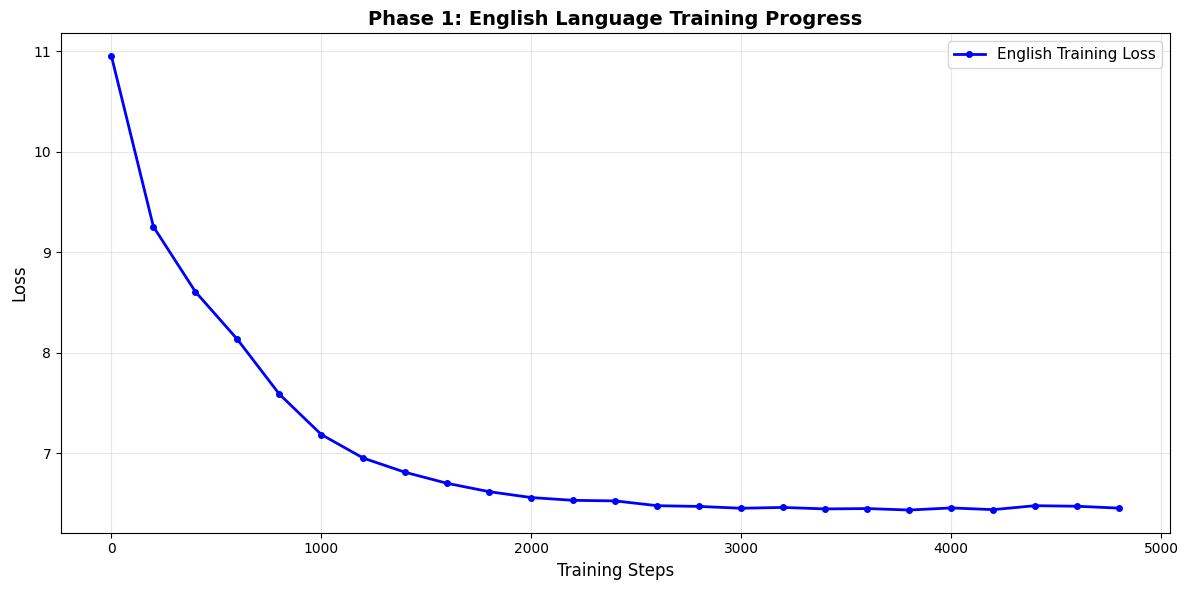

In [18]:
print("\n" + "=" * 80)
print("PHASE 1 COMPLETE!")
print("=" * 80)
print(f"✓ Initial English loss: {phase1_losses[0]:.4f}")
print(f"✓ Final English loss: {phase1_losses[-1]:.4f}")
print(f"✓ Improvement: {phase1_losses[0] - phase1_losses[-1]:.4f}")

# Plot Phase 1 results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(phase1_steps, phase1_losses, 'b-', label='English Training Loss', linewidth=2, marker='o', markersize=4)
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Phase 1: English Language Training Progress', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('phase1_training_loss.png', dpi=150, bbox_inches='tight')
plt.show()

## Step 11.2.1: Financial Training Loop

In [19]:
# Helper Functions to resume training
def save_training_state(iter_num, keep_last=2):
    """Save complete training state with iteration number"""
    checkpoint_path = f'./training_state_iter_{iter_num}.pt'
    
    state = {
        'iter_num': iter_num,
        'model_state_dict': model.module.state_dict() if is_multi_gpu else model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'steps_list': steps_list,
        'best_val_loss': best_val_loss,
        'config': config,
    }
    torch.save(state, checkpoint_path)
    print(f"   💾 Training state saved: {checkpoint_path}")
    
    # Clean up old checkpoints
    cleanup_old_checkpoints(keep_last=keep_last)

def cleanup_old_checkpoints(keep_last=2):
    """Delete old checkpoint files, keeping only the most recent N"""
    checkpoint_files = glob.glob('./training_state_iter_*.pt')
    
    if len(checkpoint_files) <= keep_last:
        return
    
    # Sort by modification time (newest first)
    checkpoint_files.sort(key=os.path.getmtime, reverse=True)
    
    # Delete old checkpoints
    deleted_count = 0
    for old_checkpoint in checkpoint_files[keep_last:]:
        try:
            os.remove(old_checkpoint)
            deleted_count += 1
        except Exception as e:
            print(f"   ⚠️ Could not delete {old_checkpoint}: {e}")
    
    if deleted_count > 0:
        print(f"   🗑️ Deleted {deleted_count} old checkpoint(s)")

def load_training_state():
    """Load most recent training state"""
    checkpoint_files = glob.glob('./training_state_iter_*.pt')
    
    if not checkpoint_files:
        return None
    
    # Get the most recent checkpoint
    latest_checkpoint = max(checkpoint_files, key=os.path.getmtime)
    print(f"📂 Loading checkpoint: {latest_checkpoint}")
    
    state = torch.load(latest_checkpoint, map_location=device)
    
    if is_multi_gpu:
        model.module.load_state_dict(state['model_state_dict'])
    else:
        model.load_state_dict(state['model_state_dict'])
    
    optimizer.load_state_dict(state['optimizer_state_dict'])
    scheduler.load_state_dict(state['scheduler_state_dict'])
    scaler.load_state_dict(state['scaler_state_dict'])
    
    return state

# Check for existing training state
resume_state = load_training_state()
if resume_state:
    start_iter = resume_state['iter_num'] + 1
    train_losses = resume_state['train_losses']
    val_losses = resume_state['val_losses']
    steps_list = resume_state['steps_list']
    best_val_loss = resume_state['best_val_loss']
    print(f"✓ Resuming training from iteration {start_iter:,}")
else:
    start_iter = 0
    print("✓ Starting fresh training")

NameError: name 'glob' is not defined

In [ ]:
# Main Training block

print("\n" + "=" * 80)
print("PHASE 2: FINANCIAL DOMAIN SPECIALIZATION")
print("=" * 80)
print("Fine-tuning on financial data (model already knows English)")

best_val_loss = float('inf')
best_model_path = './best_financial_slm.pt'
train_losses, val_losses = [], []
steps_list = []

print(f"\n⚙️ Phase 2 Configuration:")
print(f"  Learning rate: {learning_rate} (lower for fine-tuning)")
print(f"  Max iterations: {max_iters:,}")
print(f"  Gradient accumulation steps: {gradient_accumulation_steps}")
print(f"  Purpose: Learn financial concepts, terminology, analysis")

# Initial evaluation
print("\n📊 Initial evaluation (on financial data)...")
initial_losses = estimate_loss(model, eval_iters=100)
print(f"Initial losses - Train: {initial_losses['train']:.4f}, Val: {initial_losses['val']:.4f}")

# Record initial point
train_losses.append(initial_losses['train'])
val_losses.append(initial_losses['val'])
steps_list.append(0)

model.train()
lr_history = []
# Phase 2 Training loop
for iter_num in tqdm(range(start_iter, max_iters), desc="Phase 2: Financial Training"):
    lr_history.append(optimizer.param_groups[0]['lr'])

    # Evaluation
    if iter_num % eval_interval == 0 and iter_num > 0:
        losses = estimate_loss(model, eval_iters=400)
        
        print(f"\n📈 Step {iter_num:,}")
        print(f"   Train loss: {losses['train']:.4f}")
        print(f"   Val loss: {losses['val']:.4f}")
        print(f"   Learning rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        steps_list.append(iter_num)
        
        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            
            # Unwrap DataParallel before saving
            model_to_save = model.module if is_multi_gpu else model
            
            checkpoint = {
                'model_state_dict': model_to_save.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'config': config,
                'iter_num': iter_num,
                'val_loss': best_val_loss,
                'train_loss': losses['train'],
                'phase': 'financial',
            }
            torch.save(checkpoint, best_model_path)
            print(f"   💾 New best model saved! (val_loss: {best_val_loss:.4f})")
    
    # Gradient accumulation loop
    for micro_step in range(gradient_accumulation_steps):
        X, y = get_batch('train', batch_size, block_size, device, device_type)
        
        with ctx:
            logits, loss = model(X, y)
            
            if is_multi_gpu:
                loss = loss.mean()
            
            # Normalize loss to account for accumulation
            loss = loss / gradient_accumulation_steps
        
        scaler.scale(loss).backward()
    
    # Update weights after accumulation
    scaler.unscale_(optimizer)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    scaler.step(optimizer)
    scaler.update()
    optimizer.zero_grad(set_to_none=True)
    
    # Scheduler steps every iteration
    scheduler.step()

    if iter_num % (eval_interval * 10) == 0 and iter_num > 0:
        save_training_state(iter_num)
        print(f"   💾 Training state saved (can resume from here)")
        
# Final evaluation
print("\n" + "=" * 80)
print("PHASE 2 COMPLETE!")
print("=" * 80)

final_losses = estimate_loss(model, eval_iters=200)
print(f"\n📊 Final Results:")
print(f"   Best validation loss: {best_val_loss:.4f}")
print(f"   Final train loss: {final_losses['train']:.4f}")
print(f"   Final val loss: {final_losses['val']:.4f}")
print(f"   Model saved to: {best_model_path}")

print(f"\n🎯 Two-Phase Training Complete!")
print(f"   Phase 1: English structure learned")
print(f"   Phase 2: Financial knowledge added")
print(f"   Result: Model understands English AND finance")

## Step 11.2.2: Plot Training Loss Curves

In [ ]:
# Phase Comparison Plot

print("\n" + "=" * 80)
print("📊 PHASE COMPARISON")
print("=" * 80)

comparison_data = {
    "Phase 1 (English)": {
        "Initial Loss": phase1_losses[0] if phase1_losses else None,
        "Final Loss": phase1_losses[-1] if phase1_losses else None,
        "Improvement": phase1_losses[0] - phase1_losses[-1] if phase1_losses else None,
        "Iterations": phase1_iters,
        "Data Type": "General English (OpenWebText)"
    },
    "Phase 2 (Financial)": {
        "Initial Loss": train_losses[0] if train_losses else None,
        "Final Loss": train_losses[-1] if train_losses else None,
        "Best Val Loss": best_val_loss,
        "Improvement": train_losses[0] - best_val_loss if train_losses else None,
        "Iterations": max_iters,
        "Data Type": "Financial Domain (Multi-dataset)"
    }
}

for phase, metrics in comparison_data.items():
    print(f"\n{phase}:")
    for key, value in metrics.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")
        else:
            print(f"  {key}: {value}")

# Calculate overall improvement
if phase1_losses and train_losses:
    total_improvement = phase1_losses[0] - best_val_loss
    print(f"\n🎯 Overall Improvement (Phase 1 start → Phase 2 best): {total_improvement:.4f}")

In [ ]:
## Plot Comparison

print("\n" + "=" * 80)
print("📊 PHASE COMPARISON")
print("=" * 80)

comparison_data = {
    "Phase 1 (English)": {
        "Initial Loss": phase1_losses[0] if phase1_losses else None,
        "Final Loss": phase1_losses[-1] if phase1_losses else None,
        "Improvement": phase1_losses[0] - phase1_losses[-1] if phase1_losses else None,
        "Iterations": phase1_iters,
        "Data Type": "General English (OpenWebText)"
    },
    "Phase 2 (Financial)": {
        "Initial Loss": train_losses[0] if train_losses else None,
        "Final Loss": train_losses[-1] if train_losses else None,
        "Best Val Loss": best_val_loss,
        "Improvement": train_losses[0] - best_val_loss if train_losses else None,
        "Iterations": max_iters,
        "Data Type": "Financial Domain (Multi-dataset)"
    }
}

for phase, metrics in comparison_data.items():
    print(f"\n{phase}:")
    for key, value in metrics.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")
        else:
            print(f"  {key}: {value}")

# Calculate overall improvement
if phase1_losses and train_losses:
    total_improvement = phase1_losses[0] - best_val_loss
    print(f"\n🎯 Overall Improvement (Phase 1 start → Phase 2 best): {total_improvement:.4f}")

In [ ]:
# Learning Rate Visulization
plt.figure(figsize=(12, 6))
plt.plot(steps_list, lr_history, 'purple', linewidth=2)
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Learning Rate', fontsize=12)
plt.title('Phase 2: Learning Rate Schedule', fontsize=14, fontweight='bold')
plt.yscale('log')  # Log scale for better visibility
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('phase2_learning_rate.png', dpi=150, bbox_inches='tight')
plt.show()

### Step 12: Overall Loss Plotting

In [ ]:
print("\n" + "=" * 80)
print("CREATING COMBINED TRAINING VISUALIZATION")
print("=" * 80)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Phase 1 plot
ax1.plot(phase1_steps, phase1_losses, 'b-', label='English Training', linewidth=2, marker='o', markersize=4)
ax1.set_xlabel('Training Steps', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Phase 1: English Structure Learning', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Phase 2 plot
ax2.plot(steps_list, train_losses, 'g-', label='Train Loss', linewidth=2, marker='o', markersize=4)
ax2.plot(steps_list, val_losses, 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=4)
ax2.set_xlabel('Training Steps', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('Phase 2: Financial Domain Specialization', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('combined_training_progress.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Combined training visualization saved as 'combined_training_progress.png'")

print(f"\n🎯 Two-Phase Training Complete!")
print(f"   Phase 1: English structure learned")
print(f"   Phase 2: Financial knowledge added")
print(f"   Result: Model understands English AND finance")

## Step 13: Model Summary

In [ ]:
# Create Model Card & Save Training Summary

print("\n" + "=" * 80)
print("CREATING MODEL DOCUMENTATION")
print("=" * 80)

from datetime import datetime

# Get config safely
if hasattr(model, 'module'):
    config = model.module.config
elif hasattr(model, 'config'):
    config = model.config

# Pre-calculate values to avoid format errors
phase1_final = f"{phase1_losses[-1]:.4f}" if phase1_losses else 'N/A'
english_tokens = f"{len(english_train_data):,}" if 'english_train_data' in locals() else 'N/A'

# Create model card
model_card = f"""
# Financial SLM - Model Card

## Model Details
- **Model Name**: Financial Small Language Model (SLM)
- **Model Type**: GPT-2 Fine-tuned Transformer
- **Parameters**: {n_params/1e6:.2f}M
- **Architecture**: {config.n_layer} layers, {config.n_head} attention heads, {config.n_embd} embedding dim
- **Vocabulary**: GPT-2 (50,257 tokens)
- **Training Date**: {datetime.now().strftime("%B %d, %Y")}

## Training Approach
This model was trained using a **two-phase curriculum learning approach**:

### Phase 1: General English Language Learning
- **Dataset**: OpenWebText (general English text)
- **Purpose**: Learn fundamental language structure, grammar, and syntax
- **Iterations**: {phase1_iters:,}
- **Final Loss**: {phase1_final}
- **Outcome**: Model gains understanding of English before specializing

### Phase 2: Financial Domain Specialization
- **Datasets**: Finance Alpaca + Financial PhraseBank + Custom Investment Data
- **Purpose**: Specialize in financial concepts, terminology, and analysis
- **Iterations**: {max_iters:,}
- **Best Validation Loss**: {best_val_loss:.4f}
- **Outcome**: Model combines English fluency with financial expertise

## Training Data

### Phase 1: General English (OpenWebText)
- General-purpose English text corpus
- Tokens: {english_tokens}
- Purpose: Foundation language understanding

### Phase 2: Financial Domain
- **Finance Alpaca**: {len(finance_alpaca['train']):,} financial Q&A examples
- **Financial PhraseBank**: {len(financial_phrasebank['train']):,} sentiment analysis examples
- **Custom Investment Data**: {len(custom_dataset):,} curated investment examples
- **Total Training Examples**: {len(dataset_split['train']):,}
- **Total Tokens**: {total_tokens:,}

## Training Configuration

### Phase 1 Configuration
- **Optimizer**: AdamW (lr={phase1_lr}, weight_decay=0.1)
- **Scheduler**: Linear warmup ({phase1_warmup_steps:,} steps) + Cosine annealing
- **Iterations**: {phase1_iters:,}

### Phase 2 Configuration
- **Optimizer**: AdamW (lr={learning_rate}, weight_decay=0.1)
- **Batch Size**: {batch_size} (effective: {batch_size * gradient_accumulation_steps})
- **Training Steps**: {max_iters:,}
- **Learning Rate Schedule**: Linear warmup ({warmup_steps:,} steps) + Cosine annealing
- **Gradient Clipping**: max_norm=1.0
- **Mixed Precision**: {dtype}
- **Hardware**: {'GPU (CUDA)' if device_type == 'cuda' else 'CPU'}

## Performance
- **Phase 1 Final Loss**: {phase1_final}
- **Phase 2 Best Validation Loss**: {best_val_loss:.4f}
- **Phase 2 Final Train Loss**: {final_losses['train']:.4f}
- **Phase 2 Final Val Loss**: {final_losses['val']:.4f}
- **Total Evaluations**: {len(train_losses):,}

## Capabilities
- Financial question answering
- Investment analysis and recommendations
- Sentiment analysis of financial statements
- Company financial health assessment
- Portfolio diversification advice
- Financial concept explanations
- Market trend interpretation
- Risk assessment guidance

## Limitations
- **Educational purposes only** - not financial advice
- May generate incorrect or outdated information
- Should not be sole basis for investment decisions
- Requires human verification and professional advice
- Training data cutoff may not reflect latest market conditions
- Small model size may limit reasoning capabilities

## Intended Use
- Financial education and learning
- Investment research assistance
- Financial literacy improvement
- Prototype for financial chatbots
- Research on domain adaptation techniques

## Ethical Considerations
- Always include disclaimers about not being financial advice
- Users should consult licensed financial advisors
- Model outputs should be fact-checked
- Not suitable for automated trading systems
- May reflect biases present in training data
- Should not be used for high-stakes financial decisions

## Citation
If you use this model, please cite:
Financial SLM (2025) by Satgun Singh Sodhi
{n_params/1e6:.1f}M parameter GPT-2 transformer with two-phase training
Phase 1: General English (OpenWebText)
Phase 2: Financial domain (Finance Alpaca + Financial PhraseBank + Custom data)
"""

# Save model card to file
with open('README.md', 'w') as f:
    f.write(model_card)

print("✓ Model card saved: README.md")

# Print training summary
print("\n" + "=" * 80)
print("📊 TRAINING SUMMARY")
print("=" * 80)

print(f"\n🔧 Model Configuration:")
print(f"  Total parameters: {n_params:,} ({n_params/1e6:.2f}M)")
print(f"  Layers: {config.n_layer}")
print(f"  Attention heads: {config.n_head}")
print(f"  Embedding dimension: {config.n_embd}")
print(f"  Block size: {block_size}")
print(f"  Vocabulary size: {config.vocab_size:,}")

# Safe Phase 1 printing
if phase1_losses:
    print(f"\n📚 Phase 1 - English Training:")
    print(f"  Iterations: {phase1_iters:,}")
    print(f"  Initial loss: {phase1_losses[0]:.4f}")
    print(f"  Final loss: {phase1_losses[-1]:.4f}")
    improvement_p1 = phase1_losses[0] - phase1_losses[-1]
    print(f"  Improvement: {improvement_p1:.4f}")

print(f"\n📚 Phase 2 - Financial Training:")
print(f"  Total training examples: {len(dataset_split['train']):,}")
print(f"  Total test examples: {len(dataset_split['test']):,}")
print(f"  Total tokens: {total_tokens:,}")
print(f"  Avg tokens per example: {total_tokens / len(combined_dataset):.1f}")

print(f"\n⚙️ Phase 2 Configuration:")
print(f"  Learning rate: {learning_rate}")
print(f"  Training iterations: {max_iters:,}")
print(f"  Batch size: {batch_size}")
print(f"  Gradient accumulation: {gradient_accumulation_steps}")
print(f"  Effective batch size: {batch_size * gradient_accumulation_steps}")
print(f"  Warmup steps: {warmup_steps:,}")
print(f"  Eval interval: {eval_interval}")
print(f"  Mixed precision: {dtype}")

print(f"\n📈 Phase 2 Performance:")
print(f"  Evaluations performed: {len(train_losses):,}")
print(f"  Best validation loss: {best_val_loss:.4f}")

if len(train_losses) > 0:
    initial_train = train_losses[0].item() if torch.is_tensor(train_losses[0]) else train_losses[0]
    final_train = train_losses[-1].item() if torch.is_tensor(train_losses[-1]) else train_losses[-1]
    initial_val = val_losses[0].item() if torch.is_tensor(val_losses[0]) else val_losses[0]
    final_val = val_losses[-1].item() if torch.is_tensor(val_losses[-1]) else val_losses[-1]
    
    print(f"  Initial train loss: {initial_train:.4f}")
    print(f"  Final train loss: {final_train:.4f}")
    print(f"  Initial val loss: {initial_val:.4f}")
    print(f"  Final val loss: {final_val:.4f}")
    
    improvement = initial_val - best_val_loss
    improvement_pct = (improvement / initial_val * 100) if initial_val > 0 else 0
    print(f"  Total improvement: {improvement:.4f} ({improvement_pct:.1f}%)")

print(f"\n💾 Files Created:")
print(f"  ✓ best_financial_slm.pt - Best model checkpoint")
print(f"  ✓ model.safetensors - SafeTensors format (safe upload)")
print(f"  ✓ phase1_training_loss.png - Phase 1 training curve")
print(f"  ✓ phase2_training_loss.png - Phase 2 training curves")
print(f"  ✓ combined_training_progress.png - Both phases visualization")
print(f"  ✓ README.md - Model documentation")

print("\n" + "=" * 80)
print("🎉 ALL STEPS COMPLETE - YOUR FINANCIAL SLM IS READY!")
print("=" * 80)
print("\n💡 Next Steps:")
print("  1. Load model: torch.load('best_financial_slm.pt')")
print("  2. Generate text: model.generate(...)")
print("  3. Review training curves in PNG files")
print("  4. Read README file for full documentation")
print("\n⚠️  Remember: This model is for educational purposes only!")
print("    Always consult licensed financial advisors for real decisions.")

## Step 14: Model Inference and Testing

In [ ]:
import tiktoken
import torch

print("\n" + "=" * 80)
print("LOADING BEST MODEL FOR INFERENCE")
print("=" * 80)

best_model_path = 'best_financial_slm.pt'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device_type = 'cuda' if 'cuda' in device else 'cpu'

# Load the best checkpoint
checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
print(f"\n📂 Loading checkpoint from: {best_model_path}")

# Create model with saved config
inference_model = GPT(checkpoint['config']).to(device)
inference_model.load_state_dict(checkpoint['model_state_dict'])
inference_model.eval()

print(f"✓ Model loaded successfully")
print(f"  Training iteration: {checkpoint['iter_num']:,}")
print(f"  Validation loss: {checkpoint['val_loss']:.4f}")

# Initialize tokenizer for inference
enc = tiktoken.get_encoding("gpt2")
print(f"\n✓ Tokenizer ready (vocab size: {enc.n_vocab:,})")

print("=" * 80)

In [ ]:
def generate_financial_response(prompt, max_tokens=200, temperature=0.7, top_k=50):
    """
    Generate a financial response from the trained model.
    
    Args:
        prompt: The input prompt (instruction/question)
        max_tokens: Maximum tokens to generate
        temperature: Sampling temperature (0.7 = balanced, 1.0 = creative, 0.5 = focused)
        top_k: Top-k sampling (limits to k most likely tokens)
    
    Returns:
        Generated text response
    """
    # Format prompt with financial template
    formatted_prompt = f"Instruction: {prompt}\nInput: \nResponse: "
    
    context = torch.tensor(enc.encode_ordinary(formatted_prompt), 
                          dtype=torch.long, device=device).unsqueeze(0)

    inference_model.eval()
    
    with torch.no_grad():
        # Remove topk to get more diverse output from undertrained model
        output = inference_model.generate(context, max_new_tokens=max_tokens, 
                               temperature=temperature)
    
    full_response = enc.decode(output[0].tolist())
    
    # Better response extraction
    if "Response:" in full_response:
        response = full_response.split("Response:")[-1]
        # Stop at "Instruction" or "End"
        for stop_word in ["\nInstruction", "End", "\n\n\n"]:
            if stop_word in response:
                response = response.split(stop_word)[0]
        return response.strip()
    
    return full_response

print("✓ Inference function defined")

In [ ]:
print("\n" + "=" * 80)
print("🧪 TESTING MODEL WITH SAMPLE QUERIES")
print("=" * 80)

# Test queries covering different financial topics
test_queries = [
    {"category": "Investment Strategy", "query": "What is dollar-cost averaging?"},
    {"category": "Tax Planning", "query": "Should I contribute to a Roth or Traditional IRA?"},
    {"category": "Portfolio Management", "query": "How should I diversify my portfolio?"},
    {"category": "Market Analysis", "query": "What causes stock market volatility?"},
    {"category": "Risk Assessment", "query": "What is my risk tolerance as a young investor?"}
]

# Unwrap model for inference
inference_model = model.module if is_multi_gpu else model
inference_model.eval()

def generate_financial_response(prompt, max_tokens=200, temperature=0.7):
    """Generate response from trained model"""
    formatted_prompt = f"Instruction: {prompt}\n\nResponse:"
    context = torch.tensor(encoder.encode_ordinary(formatted_prompt), dtype=torch.long, device=device).unsqueeze(0)
    
    with torch.no_grad():
        output = inference_model.generate(context, max_new_tokens=max_tokens, temperature=temperature, top_k=50)
    
    full_response = encoder.decode(output[0].tolist())
    
    # Extract only the response part
    if "Response:" in full_response:
        response = full_response.split("Response:")[-1].strip()
        # Stop at next instruction marker
        for stop_word in ["Instruction:", "\n\n", "End"]:
            if stop_word in response:
                response = response.split(stop_word)[0]
        return response.strip()
    
    return full_response

print("\n📝 Running test queries...\n")

for i, test in enumerate(test_queries, 1):
    print("=" * 80)
    print(f"Test {i}/{len(test_queries)}: {test['category']}")
    print("=" * 80)
    print(f"Query: {test['query']}")
    print(f"\nResponse:")
    
    response = generate_financial_response(test['query'], max_tokens=300, temperature=0.7)
    print(response)
    print()

print("=" * 80)
print("✓ Inference testing complete!")
print("=" * 80)

## Step 15: Upload to huggingfaces as a new version of the model

In [ ]:
from safetensors.torch import save_file
from huggingface_hub import HfApi
import torch
import os
from kaggle_secrets import UserSecretsClient

print("🔄 Converting model to SafeTensors format...")

# Load checkpoint
checkpoint = torch.load('/kaggle/working/best_financial_slm.pt', map_location='cpu', weights_only=False)

# Extract just the model weights
if 'model_state_dict' in checkpoint:
    state_dict = checkpoint['model_state_dict']
else:
    state_dict = checkpoint

# Clone tensors to break weight sharing (fixes the RuntimeError)
state_dict_cloned = {k: v.clone().contiguous() for k, v in state_dict.items()}

# Save as safetensors with cloned weights
save_file(state_dict_cloned, '/kaggle/working/model.safetensors')
print("✓ Converted to SafeTensors format (weight sharing resolved)")

# Get token from Kaggle secrets
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")

api = HfApi(token=hf_token)

# Upload only specific files
print("📤 Uploading model files to Hugging Face Hub...")

# Upload folder with allow_patterns (safetensors and markdown only)
api.upload_folder(
    folder_path="/kaggle/working/",
    repo_id="satgun/finpeak-ai",
    repo_type="model",
    allow_patterns=["*.safetensors", "*.md", "README.md", "config.json"],  # Safe formats only
    commit_message="Upload finpeak-ai model (SafeTensors) and documentation"
)

print("✓ Upload complete!")
print("🔗 Model available at: https://huggingface.co/satgun/finpeak-ai")
print("✅ Model is marked as SAFE (SafeTensors format)")